In [1]:
from Imports import *
from Helper import *
from Preprocessing import *
from Plotting import *
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.3)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 128

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([87266, 16, 16])
dR Mean: torch.Size([87266])
dR STD: torch.Size([87266])
Pixel Mean: torch.Size([87266])
Pixel STD: torch.Size([87266])
ΔR min: 0.0
ΔR max: 2.203810453414917
ΔR mean min: 0.003941118251532316
ΔR mean max: 0.0156550332903862
ΔR std min: 0.020212490111589432
ΔR std max: 0.14540068805217743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.00432002916932106
Pixel std min: 0.009188652969896793
Pixel std max: 0.06249340996146202


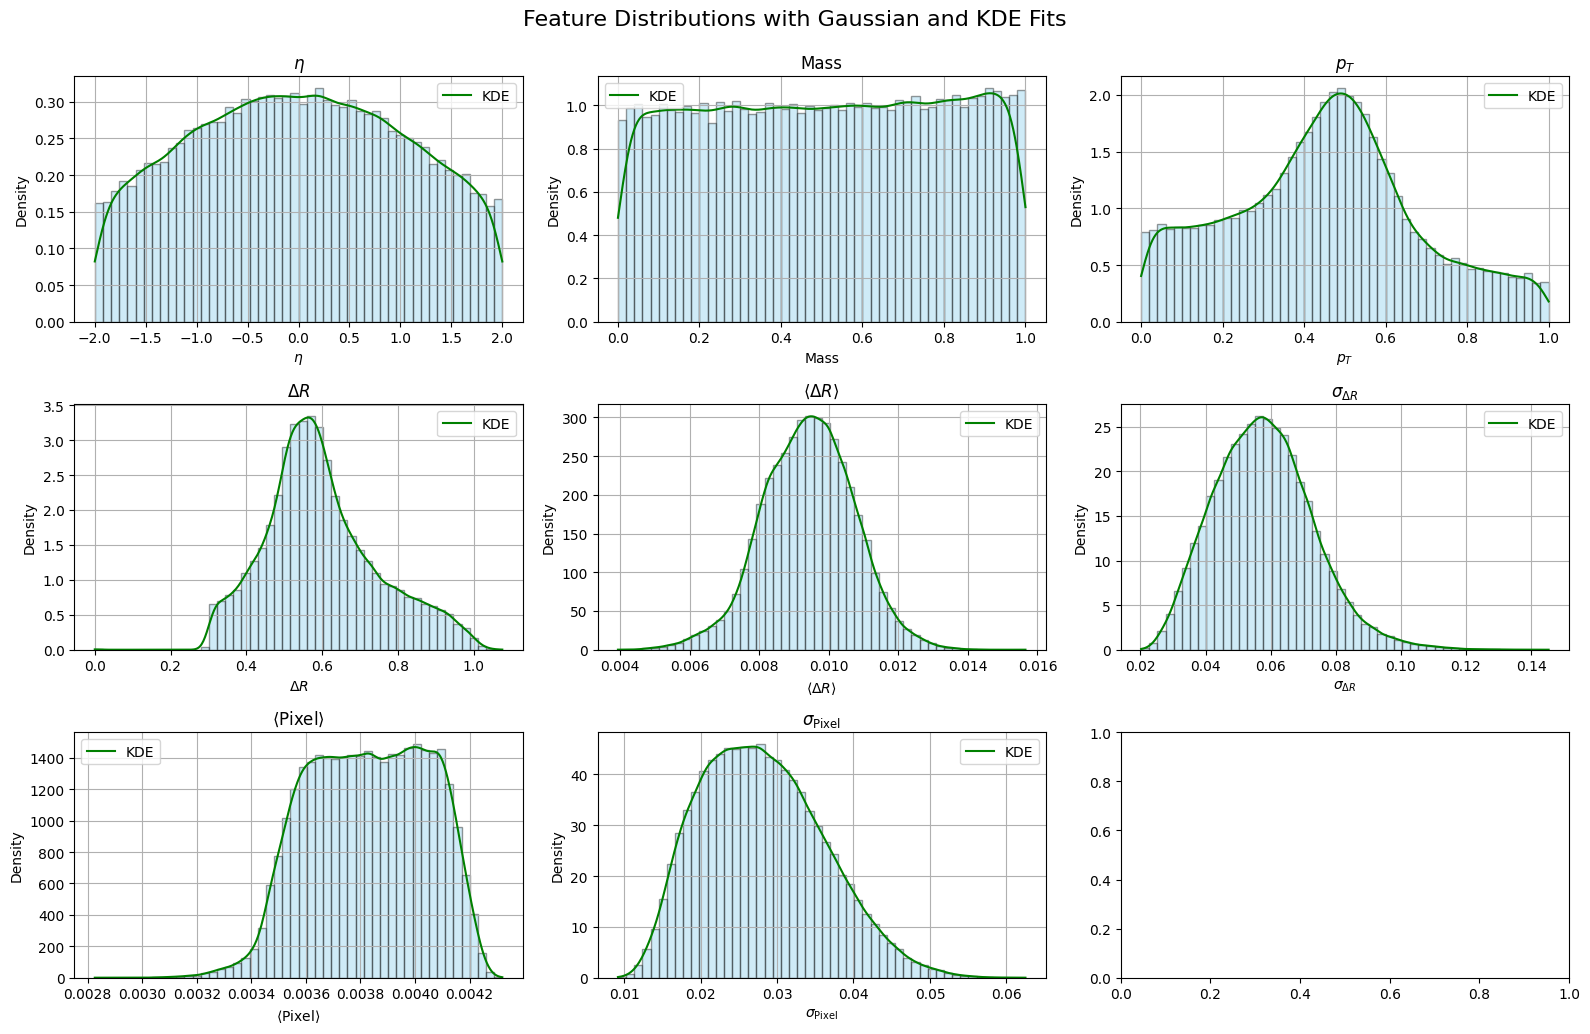

Number of samples: 87266
Image shape: torch.Size([87266, 16, 16])
Feature shape: torch.Size([87266, 9])


In [4]:
batch_size = 128*3
n_events = int(.1 * jet_mass_data['image'].shape[0])

latent_dim = 256
lr = 1e-4
n_epochs = 100
num = 4

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [8]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-6)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [6]:
## Load a previous model
# Replace with the desired filename
load = False

if load:
    load_path = "models/class_gan_short_model_m14_2001.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")

[Epoch 1/100] [D loss: 0.0062] [G loss: 5.1844] [Validity_loss: 0.9038] 
 [Stat_loss: 4.1782] [NNZ_loss: 0.1024]
Sample feature coding: [0.         1.6138507  0.02949721 0.43746874 0.49401706 0.01064923
 0.05221023 0.00379808 0.01994228]


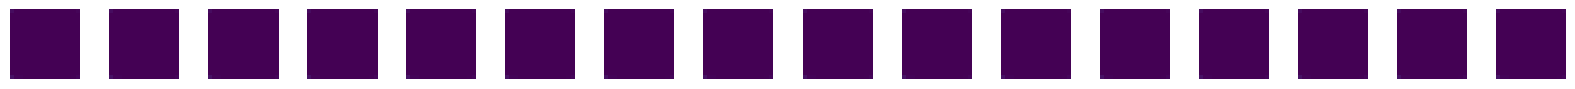

[Epoch 2/100] [D loss: 1.5168] [G loss: 4.2471] [Validity_loss: 0.0241] 
 [Stat_loss: 4.1479] [NNZ_loss: 0.0751]
Sample feature coding: [ 1.         -1.2112476   0.9465411   0.5175931   0.8210989   0.01163335
  0.03614433  0.00353564  0.01611977]


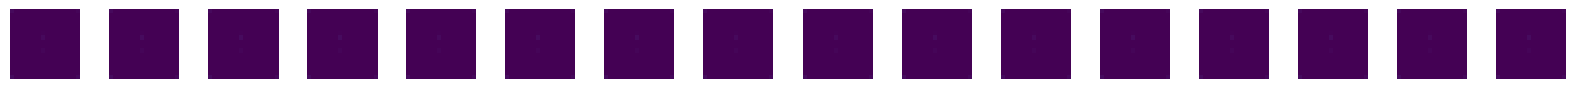

[Epoch 3/100] [D loss: 0.8530] [G loss: 2.6640] [Validity_loss: 0.1002] 
 [Stat_loss: 2.4877] [NNZ_loss: 0.0761]
Sample feature coding: [ 1.         -1.7449139   0.72574717  0.42406526  0.6824655   0.00780688
  0.06714363  0.00380065  0.04847968]


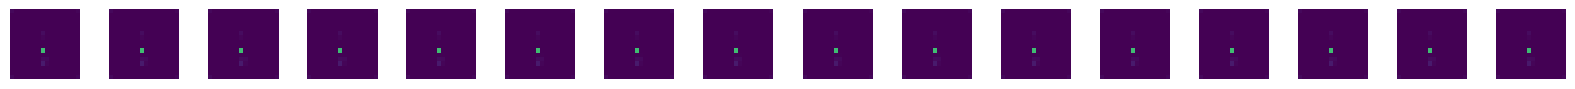

[Epoch 4/100] [D loss: 0.7273] [G loss: 108.2864] [Validity_loss: 0.1191] 
 [Stat_loss: 108.0856] [NNZ_loss: 0.0817]
Sample feature coding: [ 0.         -0.6490617   0.5175612   0.31512624  0.6070938   0.00847984
  0.05359801  0.00374428  0.01991417]


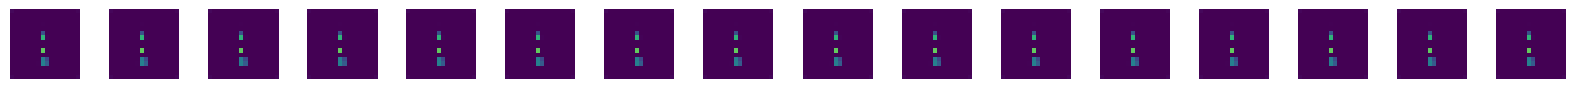

[Epoch 5/100] [D loss: 0.7483] [G loss: 2.1121] [Validity_loss: 0.1092] 
 [Stat_loss: 1.9264] [NNZ_loss: 0.0765]
Sample feature coding: [ 1.         -0.34713113  0.22452447  0.4853636   0.77420056  0.00931836
  0.06409481  0.00386437  0.01834049]


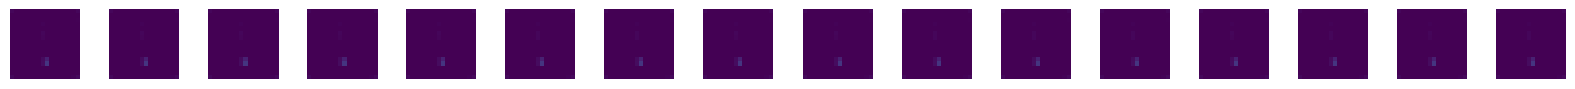

[Epoch 6/100] [D loss: 0.7597] [G loss: 0.3573] [Validity_loss: 0.0860] 
 [Stat_loss: 0.1999] [NNZ_loss: 0.0714]
Sample feature coding: [1.         0.4450855  0.7079981  0.38827366 0.54967535 0.00644945
 0.05615908 0.00380202 0.03835676]


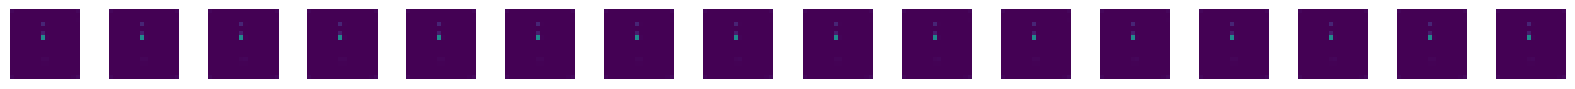

[Epoch 7/100] [D loss: 0.6953] [G loss: 3.7275] [Validity_loss: 0.1125] 
 [Stat_loss: 3.5407] [NNZ_loss: 0.0743]
Sample feature coding: [ 1.         -0.05209102  0.2889495   0.81978303  0.6399834   0.00991574
  0.04918089  0.00369099  0.04346455]


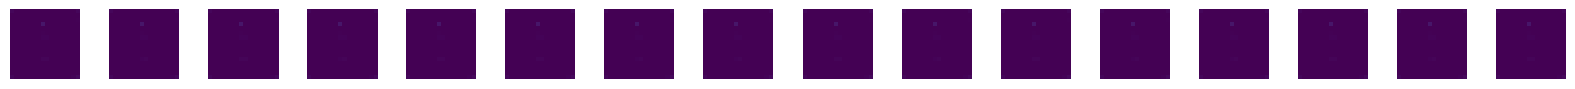

[Epoch 8/100] [D loss: 0.6838] [G loss: 89.8519] [Validity_loss: 0.1674] 
 [Stat_loss: 89.6115] [NNZ_loss: 0.0729]
Sample feature coding: [ 1.         -0.66342527  0.51629144  0.17162986  0.41839176  0.00827027
  0.04803319  0.00417786  0.02099499]


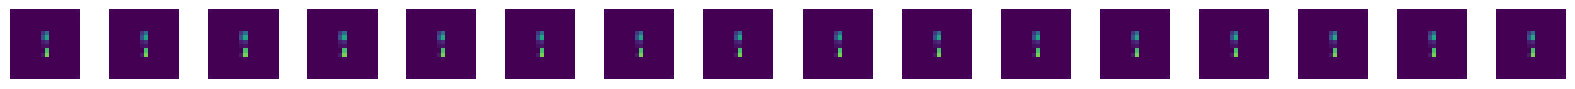

[Epoch 9/100] [D loss: 0.5990] [G loss: 3.5929] [Validity_loss: 0.2286] 
 [Stat_loss: 3.2901] [NNZ_loss: 0.0742]
Sample feature coding: [1.         0.6382808  0.12488068 0.45725736 0.47130194 0.00855576
 0.08527524 0.00409985 0.02072449]


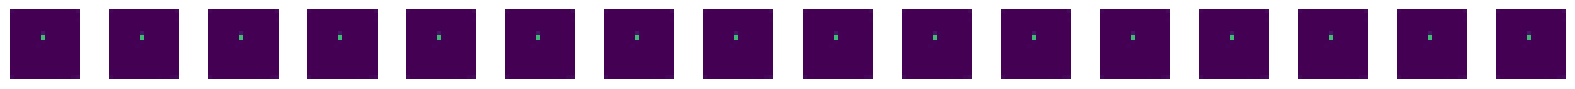

[Epoch 10/100] [D loss: 0.8370] [G loss: 2.7627] [Validity_loss: 0.0719] 
 [Stat_loss: 2.6234] [NNZ_loss: 0.0674]
Sample feature coding: [ 0.         -0.6727921   0.35730597  0.8810411   0.5414102   0.00903211
  0.04823089  0.00371408  0.03682246]


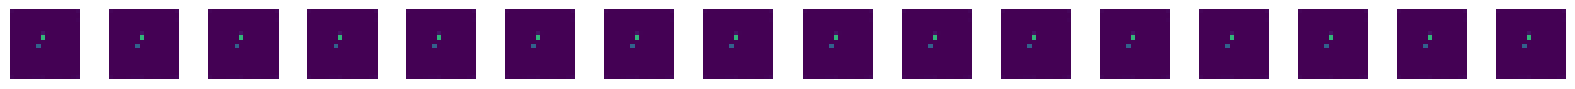

[Epoch 11/100] [D loss: 0.4616] [G loss: 3.9723] [Validity_loss: 0.1345] 
 [Stat_loss: 3.7759] [NNZ_loss: 0.0619]
Sample feature coding: [1.         0.65465254 0.21694592 0.9964461  0.6488715  0.00832674
 0.05578899 0.00372486 0.02345036]


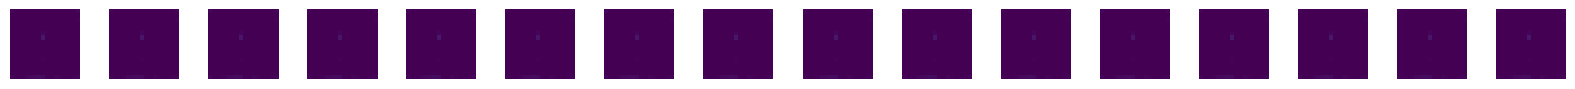

[Epoch 12/100] [D loss: 0.9990] [G loss: 312.5119] [Validity_loss: 0.1451] 
 [Stat_loss: 312.2965] [NNZ_loss: 0.0703]
Sample feature coding: [1.         1.2429153  0.5473487  0.35142332 0.8699741  0.01171259
 0.05952299 0.00405348 0.03091592]


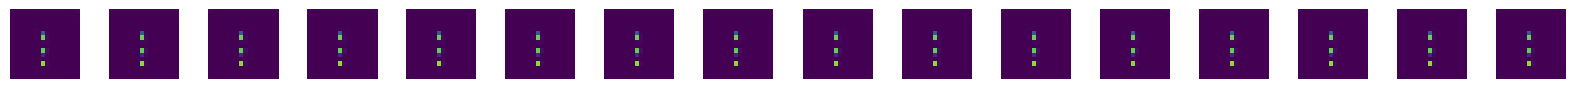

[Epoch 13/100] [D loss: 0.6858] [G loss: 1.3014] [Validity_loss: 0.1446] 
 [Stat_loss: 1.0911] [NNZ_loss: 0.0657]
Sample feature coding: [1.         1.5467169  0.14638427 0.5251727  0.48381233 0.00876467
 0.06175781 0.003668   0.01881826]


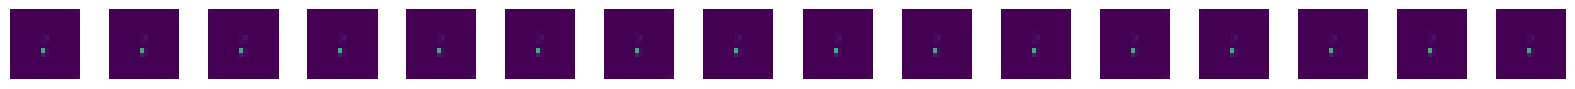

[Epoch 14/100] [D loss: 0.7104] [G loss: 3.2890] [Validity_loss: 0.1107] 
 [Stat_loss: 3.1214] [NNZ_loss: 0.0569]
Sample feature coding: [1.         1.2433676  0.66444564 0.5007104  0.63485086 0.00864595
 0.03809614 0.0035196  0.0291609 ]


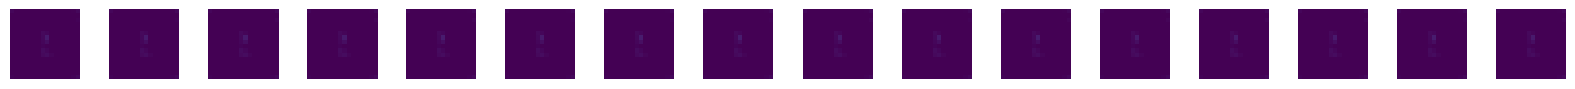

[Epoch 15/100] [D loss: 0.7012] [G loss: 2.7494] [Validity_loss: 0.1090] 
 [Stat_loss: 2.5824] [NNZ_loss: 0.0579]
Sample feature coding: [0.         0.02008612 0.7668921  0.55091375 0.5486824  0.00931348
 0.04922775 0.0040374  0.02078648]


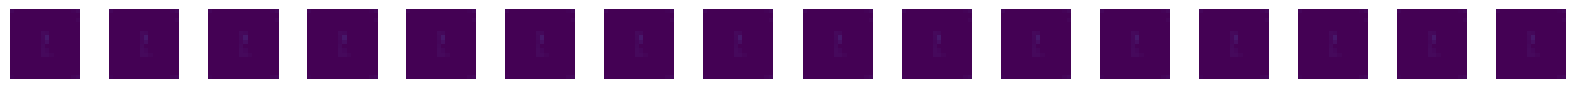

[Epoch 16/100] [D loss: 0.6977] [G loss: 2.6988] [Validity_loss: 0.1087] 
 [Stat_loss: 2.5357] [NNZ_loss: 0.0544]
Sample feature coding: [0.         1.331407   0.4674079  0.9251867  0.9196075  0.01003868
 0.06161183 0.00347517 0.03684712]


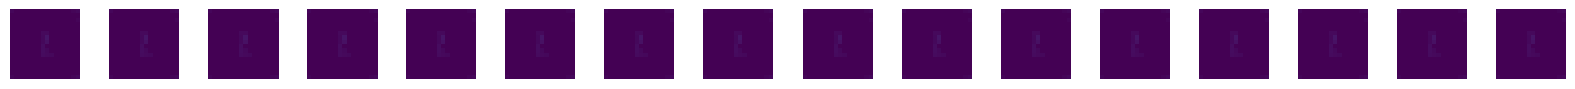

[Epoch 17/100] [D loss: 0.6952] [G loss: 2.5729] [Validity_loss: 0.1088] 
 [Stat_loss: 2.4115] [NNZ_loss: 0.0526]
Sample feature coding: [ 0.         -1.1143585   0.21571085  0.34306598  1.0375476   0.008026
  0.07260792  0.00412211  0.02950858]


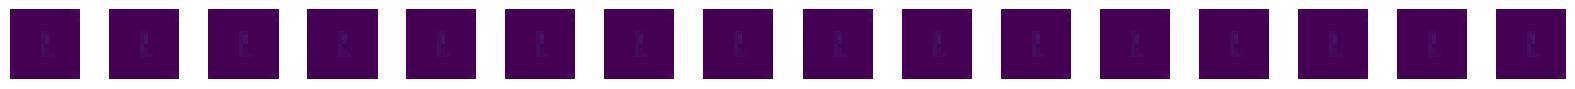

[Epoch 18/100] [D loss: 0.6946] [G loss: 1.9816] [Validity_loss: 0.1087] 
 [Stat_loss: 1.8152] [NNZ_loss: 0.0577]
Sample feature coding: [ 1.         -1.228371    0.9659163   0.2431884   0.4406237   0.00927778
  0.08070743  0.00332263  0.01703464]


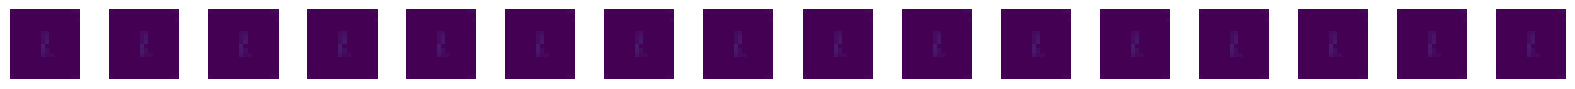

[Epoch 19/100] [D loss: 0.6949] [G loss: 1.0579] [Validity_loss: 0.1087] 
 [Stat_loss: 0.8988] [NNZ_loss: 0.0504]
Sample feature coding: [ 1.         -0.46536684  0.19800583  0.0578279   0.49945644  0.01063008
  0.0833558   0.00408299  0.03720374]


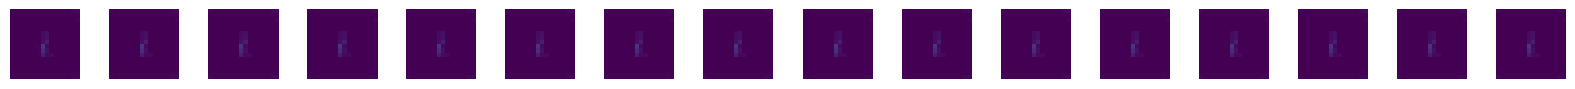

[Epoch 20/100] [D loss: 0.6949] [G loss: 0.2214] [Validity_loss: 0.1087] 
 [Stat_loss: 0.0562] [NNZ_loss: 0.0564]
Sample feature coding: [ 1.         -1.0686634   0.83745384  0.0322773   0.30575153  0.00839414
  0.06036486  0.00367485  0.03188933]


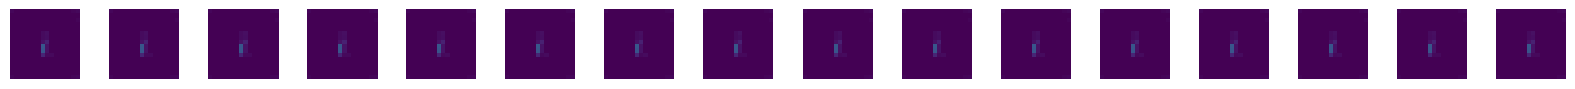

[Epoch 21/100] [D loss: 0.6964] [G loss: 0.9171] [Validity_loss: 0.1096] 
 [Stat_loss: 0.7521] [NNZ_loss: 0.0554]
Sample feature coding: [0.         0.3488226  0.704335   0.11872015 0.722952   0.00660251
 0.07583268 0.00387548 0.03884468]


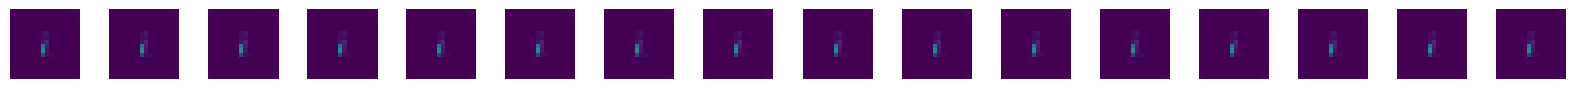

[Epoch 22/100] [D loss: 0.6954] [G loss: 1.4233] [Validity_loss: 0.1103] 
 [Stat_loss: 1.2619] [NNZ_loss: 0.0511]
Sample feature coding: [ 0.         -1.9347918   0.67020416  0.54181594  0.7590064   0.00820181
  0.05710676  0.00412475  0.02002524]


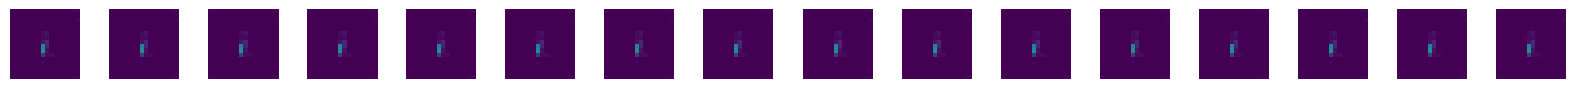

[Epoch 23/100] [D loss: 0.6933] [G loss: 1.9231] [Validity_loss: 0.1107] 
 [Stat_loss: 1.7632] [NNZ_loss: 0.0492]
Sample feature coding: [1.         1.7120297  0.1475573  0.79754305 0.48349145 0.00872584
 0.06248044 0.00405335 0.014602  ]


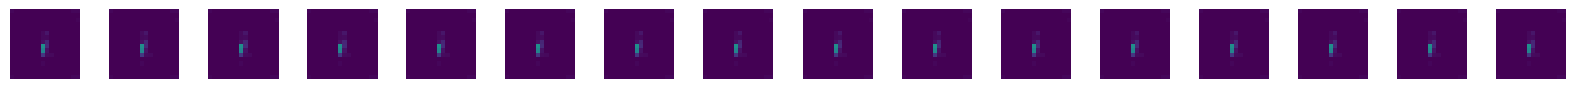

[Epoch 24/100] [D loss: 0.6922] [G loss: 0.5263] [Validity_loss: 0.1109] 
 [Stat_loss: 0.3551] [NNZ_loss: 0.0603]
Sample feature coding: [ 1.         -1.5973065   0.79039776  0.03686683  0.45463827  0.00995533
  0.04393915  0.00396817  0.03489997]


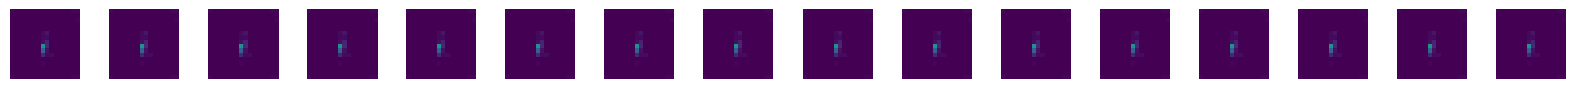

[Epoch 25/100] [D loss: 0.6926] [G loss: 0.2399] [Validity_loss: 0.1107] 
 [Stat_loss: 0.0742] [NNZ_loss: 0.0551]
Sample feature coding: [ 0.         -1.0856266   0.32923195  0.678104    0.36243594  0.01248167
  0.05031316  0.00417024  0.03285368]


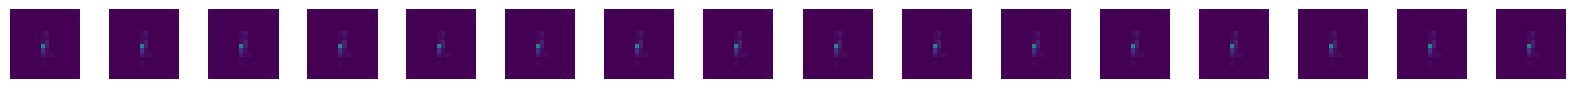

[Epoch 26/100] [D loss: 0.6927] [G loss: 0.9668] [Validity_loss: 0.1101] 
 [Stat_loss: 0.8042] [NNZ_loss: 0.0525]
Sample feature coding: [0.         0.1026374  0.07589043 0.6101641  0.88125896 0.00962855
 0.04358892 0.00393982 0.02888183]


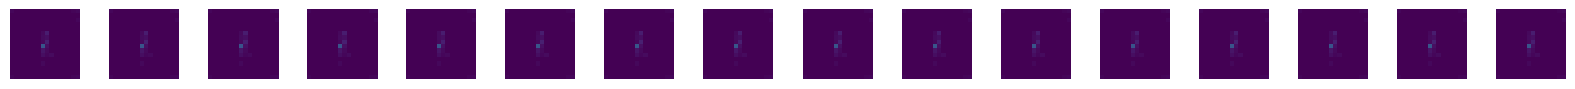

[Epoch 27/100] [D loss: 0.6927] [G loss: 1.8793] [Validity_loss: 0.1102] 
 [Stat_loss: 1.7187] [NNZ_loss: 0.0504]
Sample feature coding: [ 0.         -1.7202383   0.15653035  0.39591038  0.5220446   0.01168051
  0.04517052  0.00382749  0.01509077]


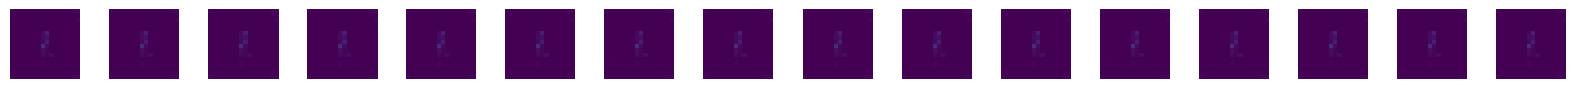

[Epoch 28/100] [D loss: 0.6919] [G loss: 0.9967] [Validity_loss: 0.1100] 
 [Stat_loss: 0.8286] [NNZ_loss: 0.0581]
Sample feature coding: [ 1.         -0.60462475  0.15572521  0.38450697  0.94315463  0.00989357
  0.06478026  0.00367921  0.03556578]


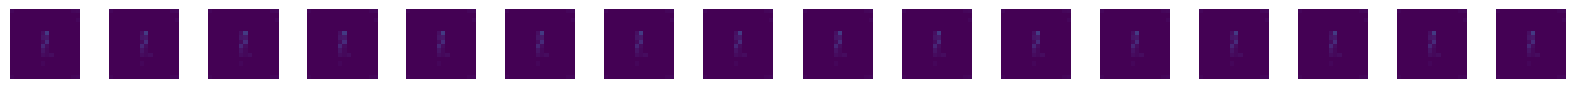

[Epoch 29/100] [D loss: 0.6916] [G loss: 0.6213] [Validity_loss: 0.1100] 
 [Stat_loss: 0.4561] [NNZ_loss: 0.0553]
Sample feature coding: [1.         0.6057498  0.95273125 0.08038596 0.7710348  0.01105952
 0.05623377 0.00364415 0.05468458]


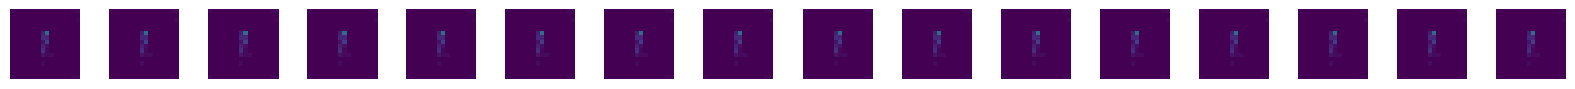

[Epoch 30/100] [D loss: 0.6921] [G loss: 4.4984] [Validity_loss: 0.1125] 
 [Stat_loss: 4.3380] [NNZ_loss: 0.0479]
Sample feature coding: [ 1.         -2.0497816   0.35734215  0.27198315  0.6888574   0.00751846
  0.05631191  0.00398525  0.02204223]


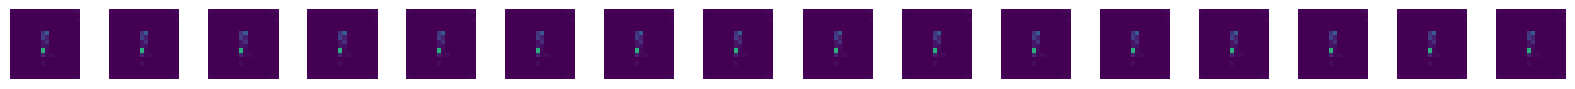

[Epoch 31/100] [D loss: 0.6931] [G loss: 0.6595] [Validity_loss: 0.1126] 
 [Stat_loss: 0.4939] [NNZ_loss: 0.0531]
Sample feature coding: [ 0.         -1.3158945   0.87824774  0.30888328  0.58849585  0.0091276
  0.05297391  0.00419756  0.03427021]


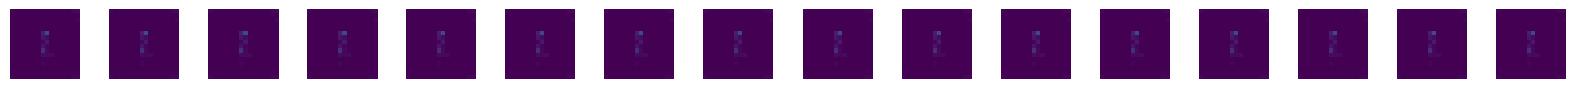

[Epoch 32/100] [D loss: 0.6919] [G loss: 1.6533] [Validity_loss: 0.1107] 
 [Stat_loss: 1.4853] [NNZ_loss: 0.0573]
Sample feature coding: [1.         1.707161   0.7868037  0.33265123 0.84899664 0.00820565
 0.06275772 0.00406714 0.02183936]


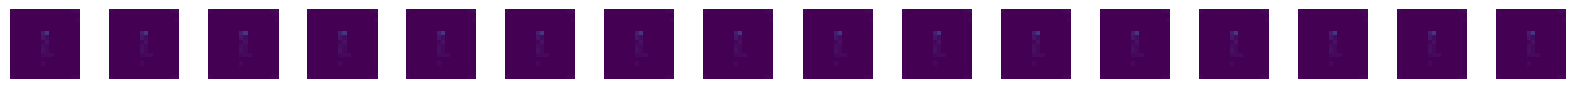

[Epoch 33/100] [D loss: 0.6894] [G loss: 0.9428] [Validity_loss: 0.1086] 
 [Stat_loss: 0.7730] [NNZ_loss: 0.0612]
Sample feature coding: [1.         0.598485   0.70264477 0.08904984 0.6620426  0.0075094
 0.05931563 0.0039951  0.03504555]


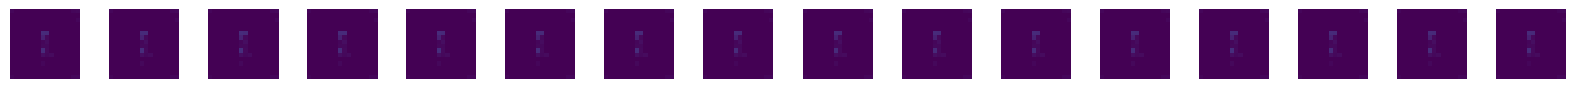

[Epoch 34/100] [D loss: 0.6876] [G loss: 0.3297] [Validity_loss: 0.1139] 
 [Stat_loss: 0.1659] [NNZ_loss: 0.0499]
Sample feature coding: [ 1.         -0.5845871   0.09029678  0.07651006  0.48289058  0.01028386
  0.0537672   0.00377685  0.02550093]


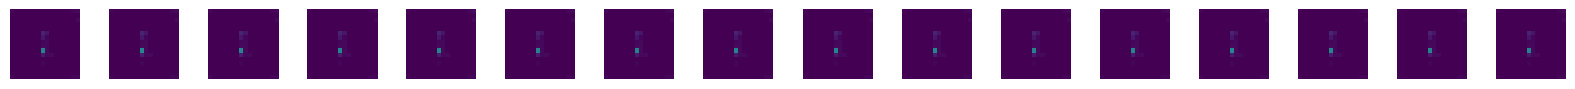

[Epoch 35/100] [D loss: 0.6867] [G loss: 2.9036] [Validity_loss: 0.1092] 
 [Stat_loss: 2.7431] [NNZ_loss: 0.0513]
Sample feature coding: [ 1.         -0.4476133   0.5383762   0.4131748   0.554692    0.01028076
  0.06305417  0.00359471  0.02497339]


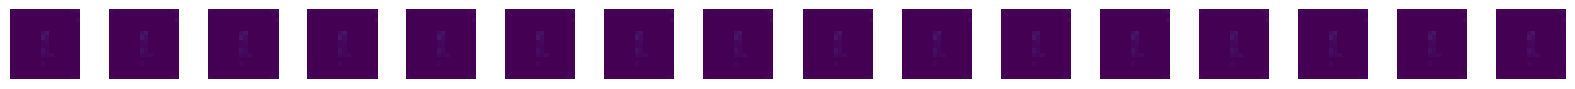

[Epoch 36/100] [D loss: 0.6949] [G loss: 9.3998] [Validity_loss: 0.1147] 
 [Stat_loss: 9.2430] [NNZ_loss: 0.0421]
Sample feature coding: [0.         0.8963669  0.4252883  0.30939552 0.7006123  0.01155929
 0.05250413 0.00365271 0.02992289]


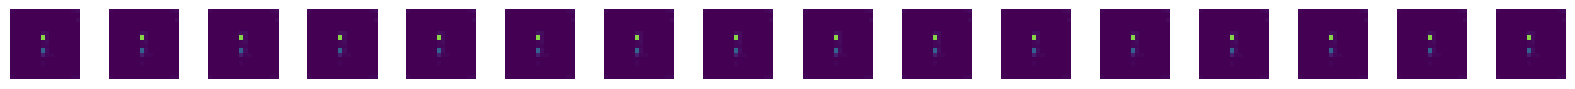

[Epoch 37/100] [D loss: 0.6843] [G loss: 5.8321] [Validity_loss: 0.1149] 
 [Stat_loss: 5.6628] [NNZ_loss: 0.0544]
Sample feature coding: [0.         0.28466043 0.9323599  0.43459827 0.6553373  0.01255555
 0.0613027  0.00383155 0.03767732]


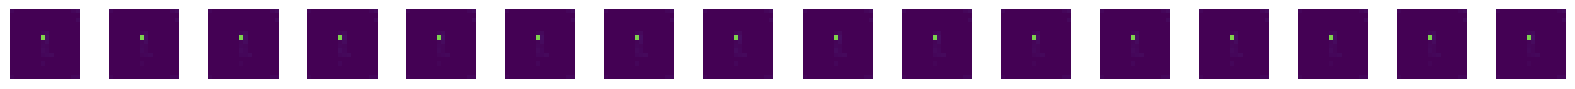

[Epoch 38/100] [D loss: 0.7431] [G loss: 2.0540] [Validity_loss: 0.0943] 
 [Stat_loss: 1.9151] [NNZ_loss: 0.0446]
Sample feature coding: [1.         0.26186892 0.3515237  0.417405   0.5390538  0.00902195
 0.06797867 0.00393219 0.0359086 ]


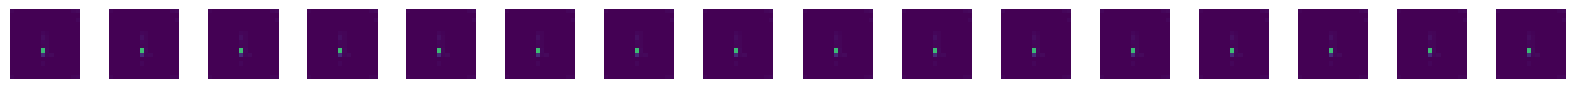

[Epoch 39/100] [D loss: 0.7042] [G loss: 3.5617] [Validity_loss: 0.1177] 
 [Stat_loss: 3.3908] [NNZ_loss: 0.0532]
Sample feature coding: [0.         0.8990308  0.15311535 0.5688577  0.62177753 0.01065344
 0.04792663 0.00360809 0.02570512]


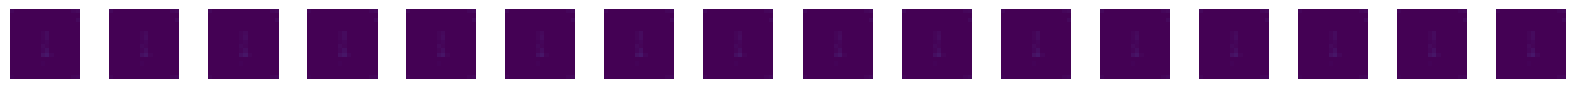

[Epoch 40/100] [D loss: 0.6896] [G loss: 3.5730] [Validity_loss: 0.1095] 
 [Stat_loss: 3.4051] [NNZ_loss: 0.0584]
Sample feature coding: [ 0.         -1.8481479   0.7216218   0.70091695  0.556537    0.00835934
  0.06176304  0.00413508  0.05099034]


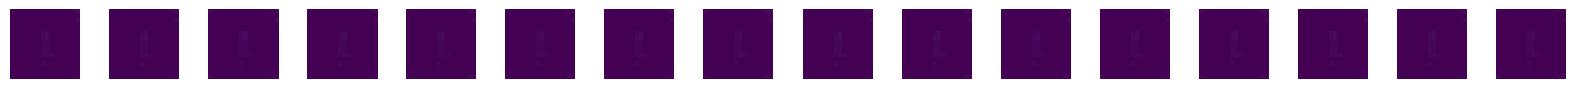

[Epoch 41/100] [D loss: 0.7024] [G loss: 4.7907] [Validity_loss: 0.1046] 
 [Stat_loss: 4.6311] [NNZ_loss: 0.0549]
Sample feature coding: [ 1.         -1.1476777   0.43093315  0.47310504  0.6532651   0.01091916
  0.04733731  0.00410839  0.02791757]


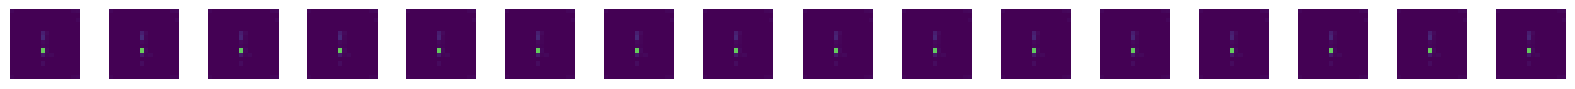

[Epoch 42/100] [D loss: 0.6875] [G loss: 3.2969] [Validity_loss: 0.1090] 
 [Stat_loss: 3.1351] [NNZ_loss: 0.0528]
Sample feature coding: [ 0.         -1.1826073   0.24859795  0.8058081   0.4718017   0.00958904
  0.05447709  0.00406825  0.02788295]


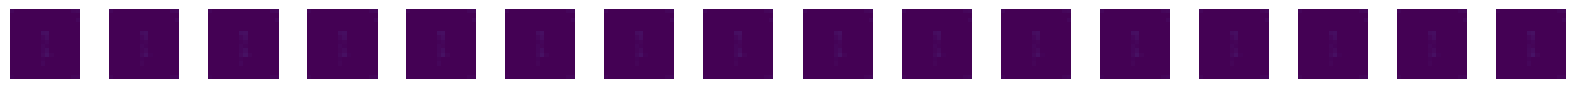

[Epoch 43/100] [D loss: 0.6877] [G loss: 7.7149] [Validity_loss: 0.1148] 
 [Stat_loss: 7.5460] [NNZ_loss: 0.0541]
Sample feature coding: [1.         0.19068095 0.27061772 0.81830734 0.56178784 0.00778536
 0.04954005 0.00321199 0.02771378]


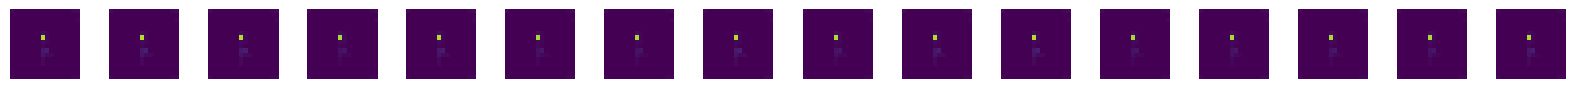

[Epoch 44/100] [D loss: 0.6805] [G loss: 0.7341] [Validity_loss: 0.1395] 
 [Stat_loss: 0.5327] [NNZ_loss: 0.0619]
Sample feature coding: [1.         0.11123025 0.81199986 0.40974662 0.6894879  0.0089315
 0.06130366 0.00386778 0.02296964]


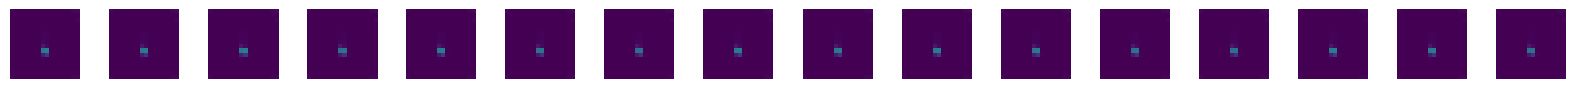

[Epoch 45/100] [D loss: 0.6722] [G loss: 3.6141] [Validity_loss: 0.1063] 
 [Stat_loss: 3.4553] [NNZ_loss: 0.0525]
Sample feature coding: [ 0.         -0.00433006  0.10290363  0.4954734   0.41063684  0.00849749
  0.05549148  0.00386136  0.02141418]


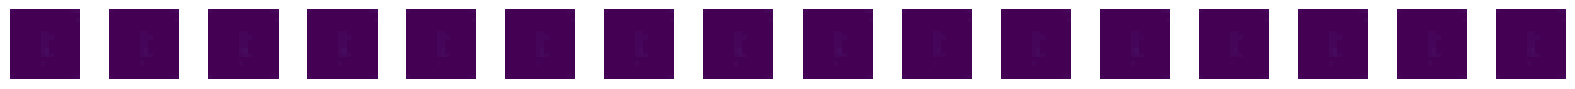

[Epoch 46/100] [D loss: 0.7145] [G loss: 5.1159] [Validity_loss: 0.1236] 
 [Stat_loss: 4.9356] [NNZ_loss: 0.0567]
Sample feature coding: [0.         0.46545056 0.42496568 0.9077298  0.42939815 0.01051313
 0.05077546 0.00404748 0.02450112]


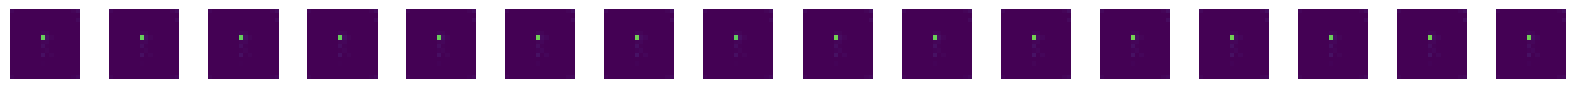

[Epoch 47/100] [D loss: 0.5384] [G loss: 113.4739] [Validity_loss: 0.1176] 
 [Stat_loss: 113.3041] [NNZ_loss: 0.0522]
Sample feature coding: [0.         0.5442629  0.83684206 0.60348076 0.5933805  0.00825252
 0.06385399 0.00376605 0.02665153]


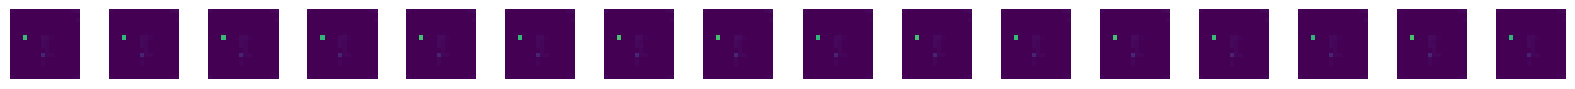

[Epoch 48/100] [D loss: 0.7147] [G loss: 296.1792] [Validity_loss: 0.1204] 
 [Stat_loss: 296.0038] [NNZ_loss: 0.0550]
Sample feature coding: [ 1.         -1.5070267   0.9687322   0.63910073  0.98878205  0.00845155
  0.05323204  0.00405292  0.01588598]


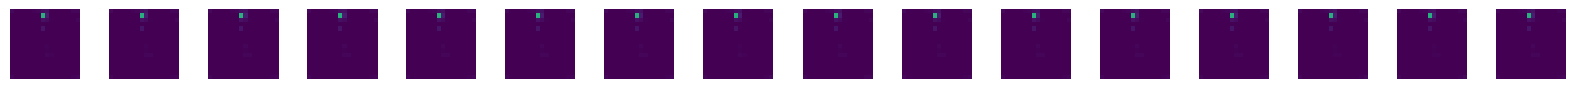

[Epoch 49/100] [D loss: 0.6980] [G loss: 2.7021] [Validity_loss: 0.1246] 
 [Stat_loss: 2.5240] [NNZ_loss: 0.0536]
Sample feature coding: [ 0.         -1.5026023   0.28418714  0.4429332   0.628416    0.01092217
  0.03298249  0.00360941  0.03602391]


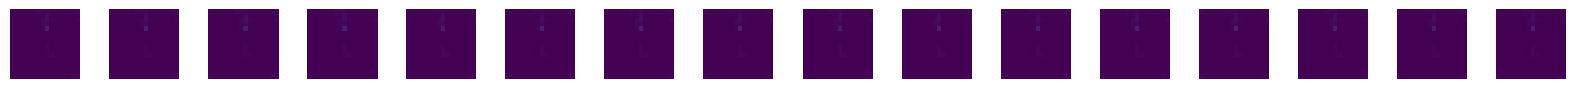

[Epoch 50/100] [D loss: 0.6761] [G loss: 2.8451] [Validity_loss: 0.1182] 
 [Stat_loss: 2.6773] [NNZ_loss: 0.0496]
Sample feature coding: [ 0.         -0.47456422  0.87978715  0.7400669   0.4662142   0.00959001
  0.05736499  0.00368351  0.03958374]


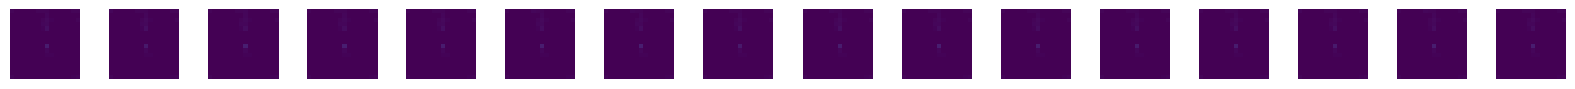

[Epoch 51/100] [D loss: 0.4687] [G loss: 3.8310] [Validity_loss: 0.1110] 
 [Stat_loss: 3.6726] [NNZ_loss: 0.0474]
Sample feature coding: [1.         0.24404088 0.31867436 0.5830754  0.8027878  0.00835315
 0.06663856 0.00401406 0.03468033]


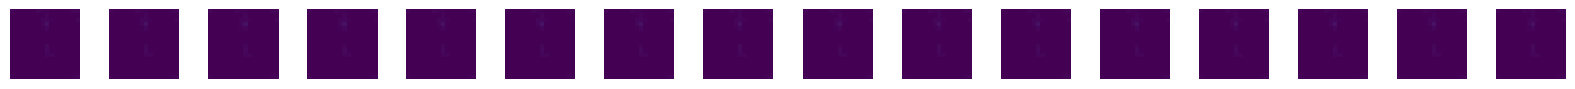

[Epoch 52/100] [D loss: 0.5724] [G loss: 0.5088] [Validity_loss: 0.1895] 
 [Stat_loss: 0.2623] [NNZ_loss: 0.0570]
Sample feature coding: [0.         0.6455819  0.45456815 0.9790872  0.6993924  0.01169609
 0.05952301 0.00411416 0.03014302]


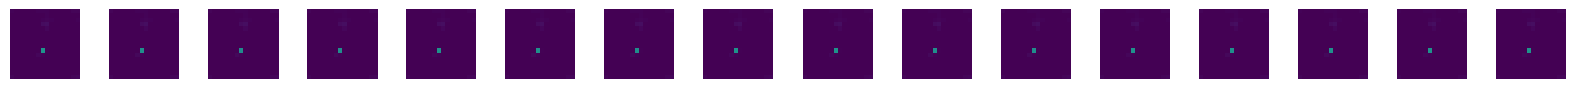

[Epoch 53/100] [D loss: 0.5257] [G loss: 0.2992] [Validity_loss: 0.1364] 
 [Stat_loss: 0.1114] [NNZ_loss: 0.0514]
Sample feature coding: [0.         0.9582544  0.7306678  0.188928   0.75701    0.00992502
 0.05728075 0.00382469 0.0247399 ]


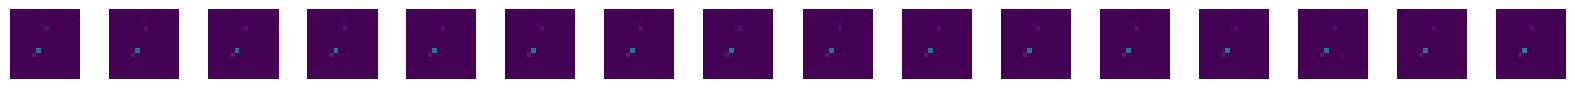

[Epoch 54/100] [D loss: 0.4776] [G loss: 5.1159] [Validity_loss: 0.1388] 
 [Stat_loss: 4.9277] [NNZ_loss: 0.0494]
Sample feature coding: [0.         0.16373576 0.835228   0.58478576 0.4533687  0.00922882
 0.07067759 0.00403888 0.03949459]


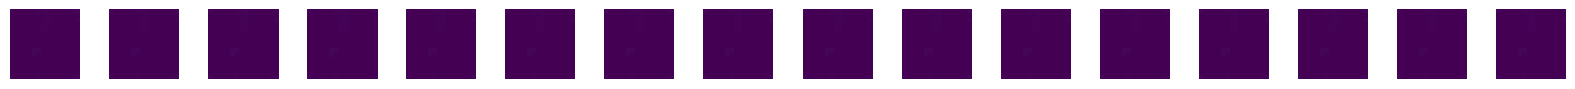

[Epoch 55/100] [D loss: 0.7125] [G loss: 10.0743] [Validity_loss: 0.1331] 
 [Stat_loss: 9.8869] [NNZ_loss: 0.0544]
Sample feature coding: [0.         0.28180137 0.84431297 0.598928   0.4265482  0.00865173
 0.04898202 0.00391502 0.03011408]


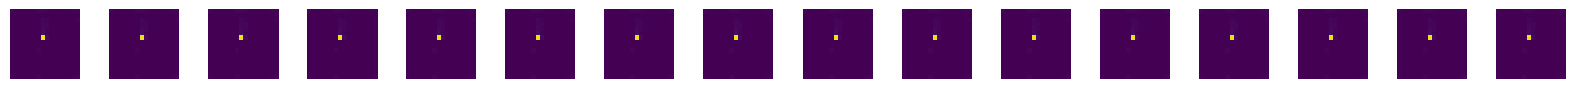

[Epoch 56/100] [D loss: 0.7006] [G loss: 11.0344] [Validity_loss: 0.1232] 
 [Stat_loss: 10.8549] [NNZ_loss: 0.0563]
Sample feature coding: [1.         1.3508542  0.93627    0.477152   0.38499328 0.01042014
 0.05727406 0.00402131 0.03247126]


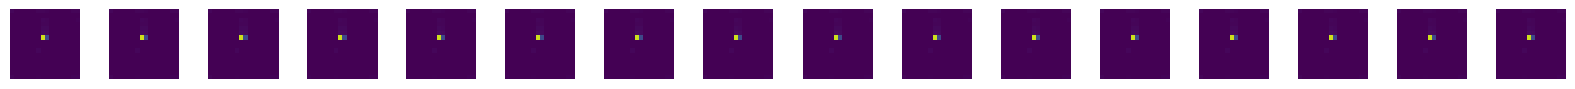

[Epoch 57/100] [D loss: 0.7003] [G loss: 37.8349] [Validity_loss: 0.1206] 
 [Stat_loss: 37.6682] [NNZ_loss: 0.0461]
Sample feature coding: [ 1.         -0.89097524  0.5871006   0.5486463   0.47180185  0.00917165
  0.04065784  0.00365885  0.02219095]


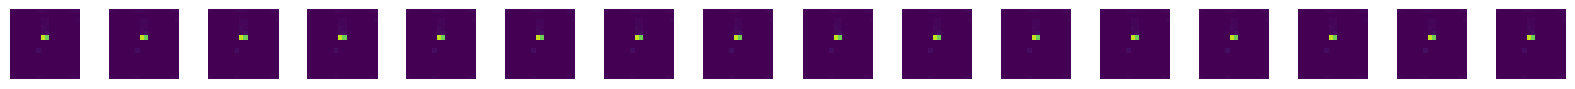

[Epoch 58/100] [D loss: 0.6830] [G loss: 37.6183] [Validity_loss: 0.1263] 
 [Stat_loss: 37.4410] [NNZ_loss: 0.0510]
Sample feature coding: [ 1.         -1.1623867   0.339967    0.46375668  0.5743223   0.01095032
  0.07173064  0.00388383  0.04812284]


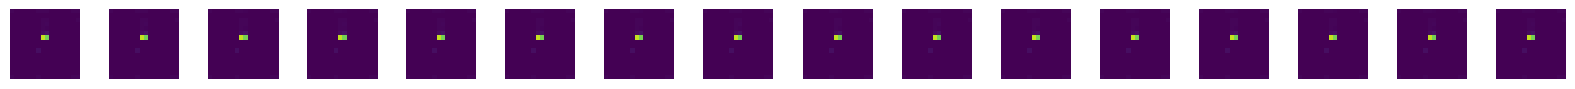

[Epoch 59/100] [D loss: 0.6970] [G loss: 0.4681] [Validity_loss: 0.1260] 
 [Stat_loss: 0.2882] [NNZ_loss: 0.0539]
Sample feature coding: [ 1.         -0.38795984  0.13427706  0.5841001   0.82824683  0.01021086
  0.07031764  0.00407988  0.01918299]


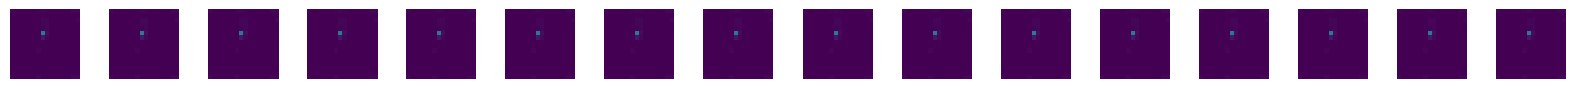

[Epoch 60/100] [D loss: 0.6910] [G loss: 0.8632] [Validity_loss: 0.1215] 
 [Stat_loss: 0.6959] [NNZ_loss: 0.0458]
Sample feature coding: [ 1.         -0.92332417  0.16589649  0.94792336  0.56578237  0.00950828
  0.06185069  0.00396204  0.0149905 ]


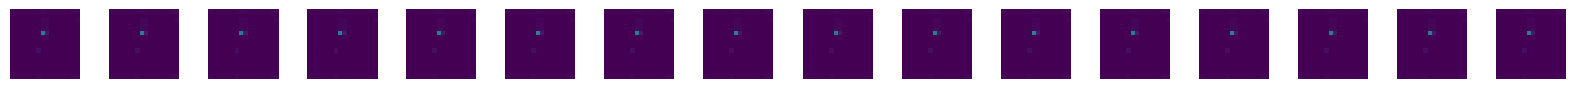

[Epoch 61/100] [D loss: 0.6788] [G loss: 2.3041] [Validity_loss: 0.1124] 
 [Stat_loss: 2.1295] [NNZ_loss: 0.0622]
Sample feature coding: [0.         0.34529492 0.8259874  0.42455143 0.6945894  0.0090201
 0.03755761 0.00380946 0.0313026 ]


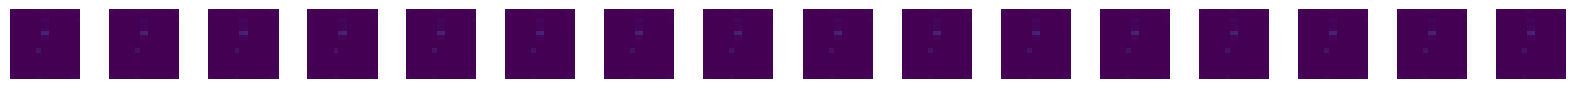

[Epoch 62/100] [D loss: 0.6289] [G loss: 4.2641] [Validity_loss: 0.1033] 
 [Stat_loss: 4.1120] [NNZ_loss: 0.0488]
Sample feature coding: [ 1.         -0.9746437   0.83593166  0.22823042  0.66497225  0.00982304
  0.03150644  0.00390632  0.03661974]


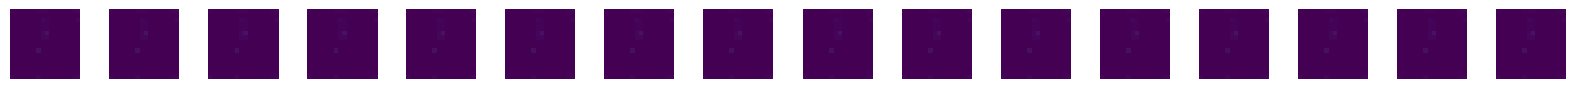

[Epoch 63/100] [D loss: 0.4895] [G loss: 4.0267] [Validity_loss: 0.1274] 
 [Stat_loss: 3.8419] [NNZ_loss: 0.0573]
Sample feature coding: [ 1.         -1.7795693   0.7948495   0.7129486   0.51267666  0.01097615
  0.07346726  0.00410225  0.02854283]


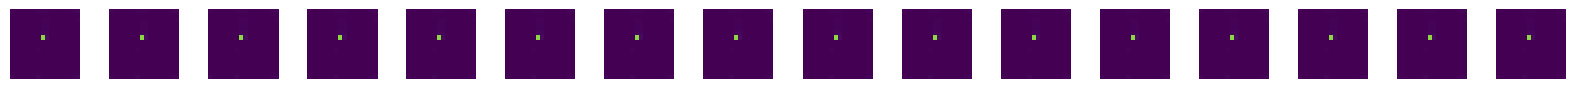

[Epoch 64/100] [D loss: 1.0968] [G loss: 15.5544] [Validity_loss: 0.0737] 
 [Stat_loss: 15.4305] [NNZ_loss: 0.0503]
Sample feature coding: [ 0.         -1.4239724   0.3488036   0.41815963  0.5275405   0.0096851
  0.05952889  0.00405963  0.01779916]


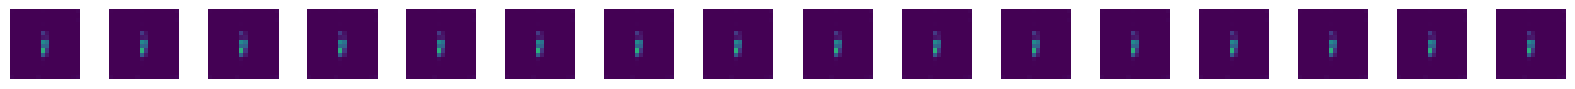

[Epoch 65/100] [D loss: 0.6793] [G loss: 18.4002] [Validity_loss: 0.1397] 
 [Stat_loss: 18.2101] [NNZ_loss: 0.0504]
Sample feature coding: [1.         0.50414205 0.01219765 0.37628734 0.44890985 0.00929669
 0.06449115 0.00379372 0.02758461]


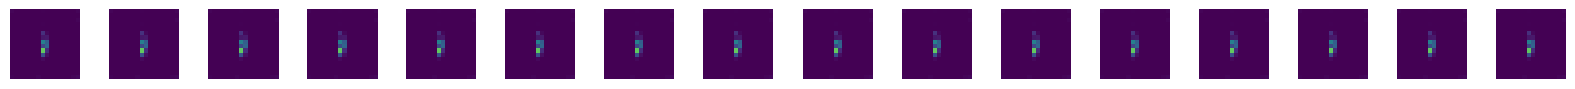

[Epoch 66/100] [D loss: 0.6947] [G loss: 0.7740] [Validity_loss: 0.1214] 
 [Stat_loss: 0.6036] [NNZ_loss: 0.0491]
Sample feature coding: [ 0.         -0.09447956  0.17028327  0.653866    0.39820614  0.01070603
  0.08697288  0.00367724  0.03697969]


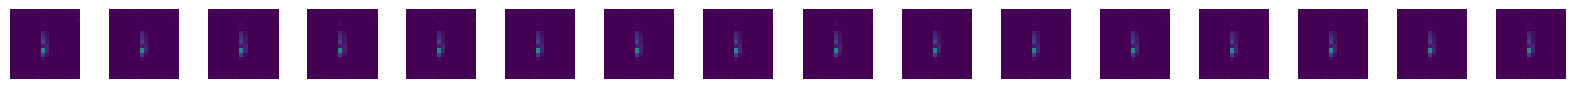

[Epoch 67/100] [D loss: 0.6934] [G loss: 0.2040] [Validity_loss: 0.1200] 
 [Stat_loss: 0.0356] [NNZ_loss: 0.0484]
Sample feature coding: [0.         1.8614587  0.04809522 0.4584369  0.46335736 0.00843498
 0.03816994 0.00393204 0.01848546]


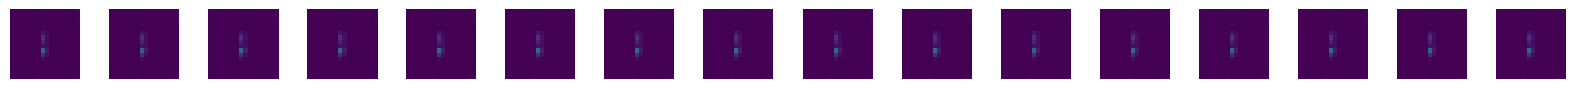

[Epoch 68/100] [D loss: 0.6931] [G loss: 0.1743] [Validity_loss: 0.1187] 
 [Stat_loss: 0.0010] [NNZ_loss: 0.0546]
Sample feature coding: [ 1.         -0.00428854  0.13166057  0.5358488   0.5073687   0.01001976
  0.03842149  0.00356431  0.01988043]


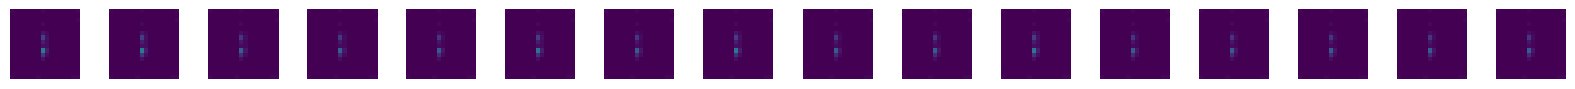

[Epoch 69/100] [D loss: 0.6928] [G loss: 0.1793] [Validity_loss: 0.1178] 
 [Stat_loss: 0.0053] [NNZ_loss: 0.0563]
Sample feature coding: [0.         0.78699505 0.65718484 0.5186603  0.6045081  0.00898353
 0.04824622 0.00350959 0.04468433]


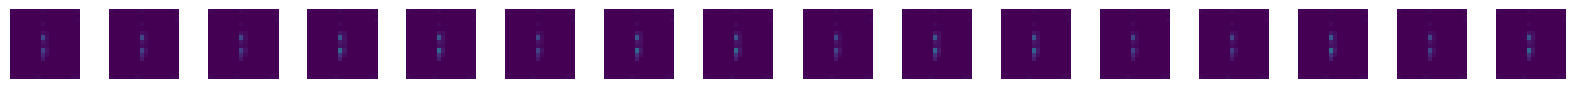

[Epoch 70/100] [D loss: 0.6964] [G loss: 8.0336] [Validity_loss: 0.1177] 
 [Stat_loss: 7.8593] [NNZ_loss: 0.0566]
Sample feature coding: [1.         0.55377126 0.5320578  0.67009765 0.4833773  0.00969732
 0.06198886 0.00351729 0.038165  ]


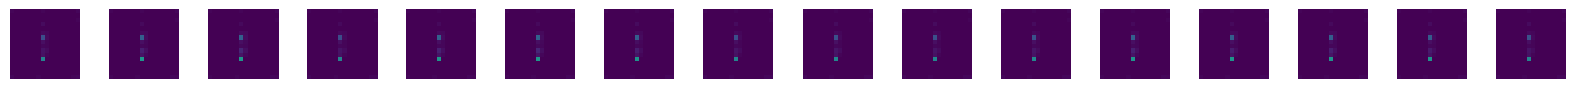

[Epoch 71/100] [D loss: 0.6944] [G loss: 18.9864] [Validity_loss: 0.1171] 
 [Stat_loss: 18.8230] [NNZ_loss: 0.0463]
Sample feature coding: [1.         0.6363967  0.6918292  0.6201419  0.55576074 0.00886287
 0.07544776 0.00395158 0.02824601]


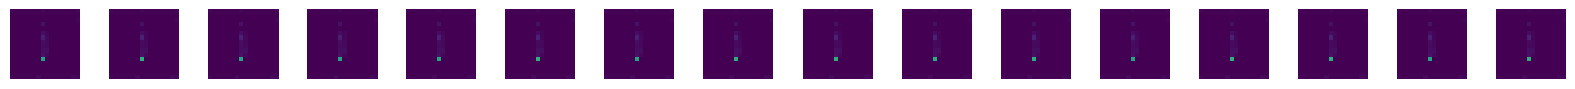

[Epoch 72/100] [D loss: 0.6924] [G loss: 7.7250] [Validity_loss: 0.1163] 
 [Stat_loss: 7.5578] [NNZ_loss: 0.0509]
Sample feature coding: [ 1.         -1.246076    0.7784048   0.45917967  0.68339336  0.0084646
  0.04818555  0.00369081  0.02169088]


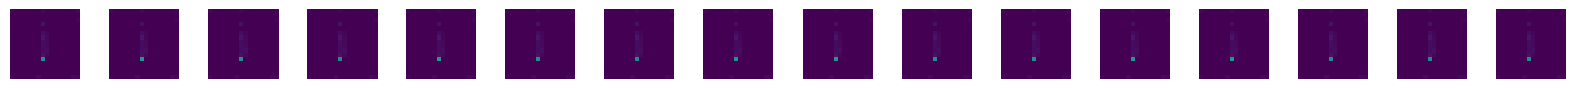

[Epoch 73/100] [D loss: 0.6929] [G loss: 7.9543] [Validity_loss: 0.1148] 
 [Stat_loss: 7.7840] [NNZ_loss: 0.0555]
Sample feature coding: [ 1.         -1.7010646   0.30131456  0.8041136   0.651966    0.00968131
  0.04116202  0.00392163  0.0281167 ]


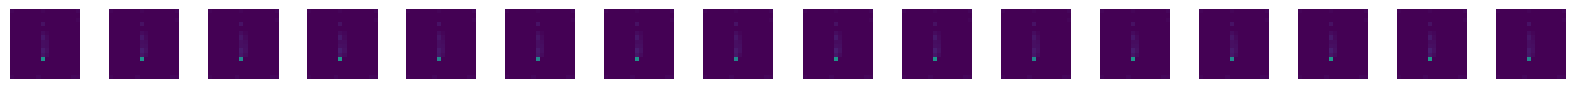

[Epoch 74/100] [D loss: 0.6925] [G loss: 0.7498] [Validity_loss: 0.1139] 
 [Stat_loss: 0.5823] [NNZ_loss: 0.0537]
Sample feature coding: [ 1.         -0.43052417  0.62349606  0.08782042  0.5796651   0.00938371
  0.06742758  0.00412012  0.02611465]


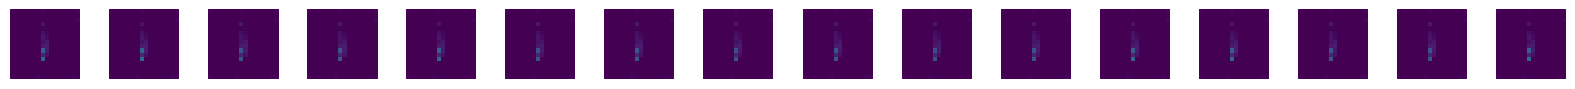

[Epoch 75/100] [D loss: 0.6927] [G loss: 0.3516] [Validity_loss: 0.1126] 
 [Stat_loss: 0.1900] [NNZ_loss: 0.0490]
Sample feature coding: [ 0.         -1.42246     0.15229903  0.31733957  0.6640952   0.01045155
  0.05326595  0.0035463   0.0258652 ]


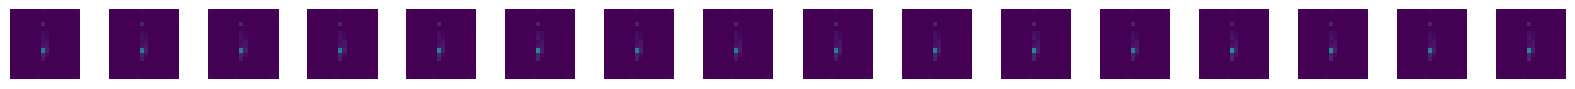

[Epoch 76/100] [D loss: 0.6927] [G loss: 0.9115] [Validity_loss: 0.1117] 
 [Stat_loss: 0.7488] [NNZ_loss: 0.0510]
Sample feature coding: [ 0.         -0.49622655  0.46736667  0.17887281  0.866498    0.00991141
  0.0659059   0.00375775  0.01757292]


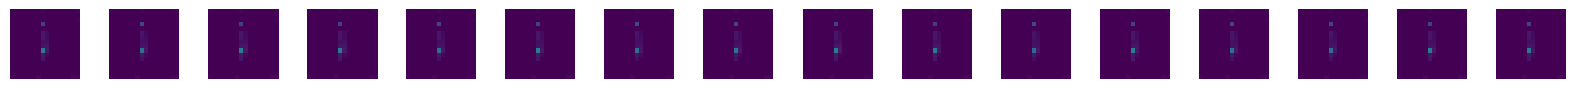

[Epoch 77/100] [D loss: 0.6907] [G loss: 1.2542] [Validity_loss: 0.1131] 
 [Stat_loss: 1.0843] [NNZ_loss: 0.0567]
Sample feature coding: [ 1.         -0.5132021   0.9216663   0.6442418   0.49084163  0.01065793
  0.06589802  0.00356922  0.02683816]


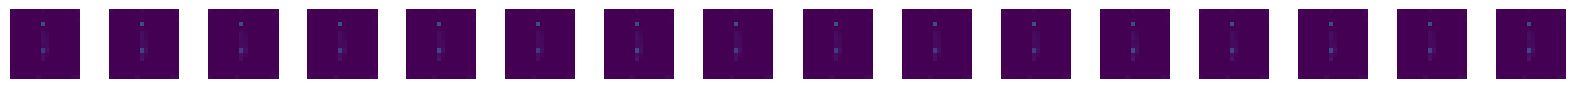

[Epoch 78/100] [D loss: 0.6927] [G loss: 6.4979] [Validity_loss: 0.1143] 
 [Stat_loss: 6.3272] [NNZ_loss: 0.0564]
Sample feature coding: [ 0.         -0.11129649  0.8651665   0.48936388  0.56629646  0.01099733
  0.0485806   0.003985    0.02549066]


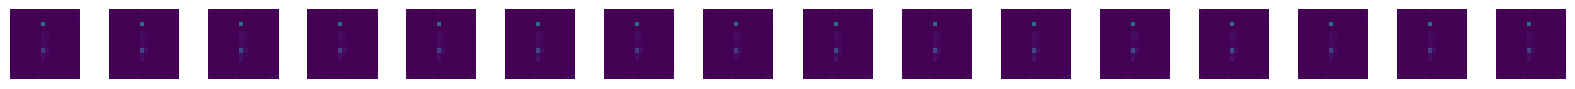

[Epoch 79/100] [D loss: 0.6929] [G loss: 1.5542] [Validity_loss: 0.1124] 
 [Stat_loss: 1.3847] [NNZ_loss: 0.0571]
Sample feature coding: [0.         1.233797   0.295789   0.05111595 0.9916058  0.008901
 0.05023354 0.00379359 0.01868925]


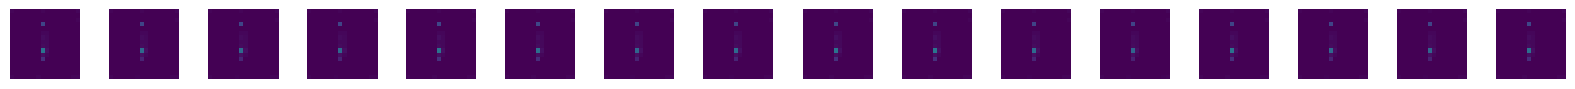

[Epoch 80/100] [D loss: 0.6909] [G loss: 0.7944] [Validity_loss: 0.1110] 
 [Stat_loss: 0.6339] [NNZ_loss: 0.0495]
Sample feature coding: [ 1.         -1.4121804   0.83071476  0.05126536  0.4642317   0.01210935
  0.04350573  0.00391332  0.03119666]


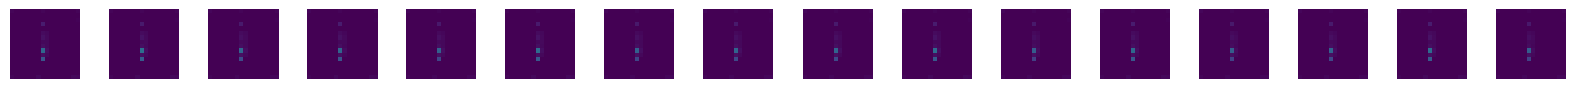

[Epoch 81/100] [D loss: 0.6909] [G loss: 1.3890] [Validity_loss: 0.1111] 
 [Stat_loss: 1.2287] [NNZ_loss: 0.0492]
Sample feature coding: [1.         0.33007628 0.5468098  0.1541949  0.8350649  0.01030192
 0.0338336  0.00404529 0.02415014]


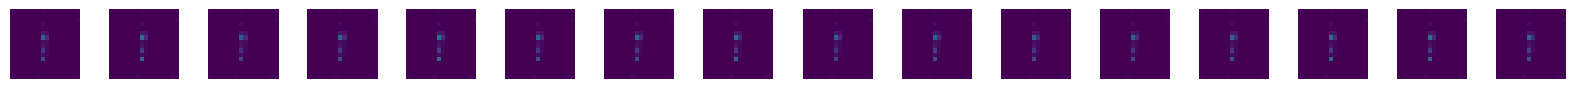

[Epoch 82/100] [D loss: 0.6912] [G loss: 0.4422] [Validity_loss: 0.1103] 
 [Stat_loss: 0.2840] [NNZ_loss: 0.0479]
Sample feature coding: [1.         0.33534047 0.37215385 0.5790398  0.49189708 0.01023411
 0.0904416  0.00375474 0.02253265]


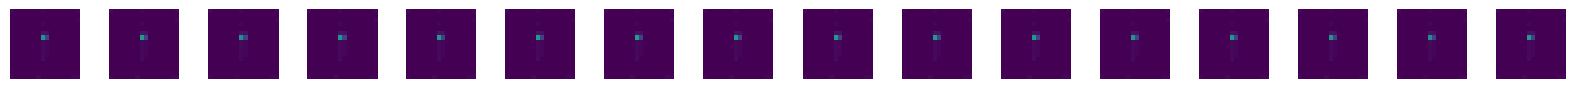

[Epoch 83/100] [D loss: 0.6879] [G loss: 0.4395] [Validity_loss: 0.1087] 
 [Stat_loss: 0.2761] [NNZ_loss: 0.0547]
Sample feature coding: [1.         1.3200611  0.20876354 0.72094184 0.5873598  0.00791635
 0.06024433 0.00357517 0.03317082]


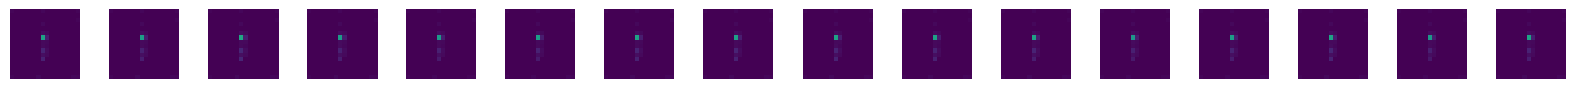

[Epoch 84/100] [D loss: 0.6862] [G loss: 2.7595] [Validity_loss: 0.1091] 
 [Stat_loss: 2.5942] [NNZ_loss: 0.0562]
Sample feature coding: [0.         1.4429281  0.7520862  0.956345   0.5597561  0.00810985
 0.0521616  0.00380659 0.03542672]


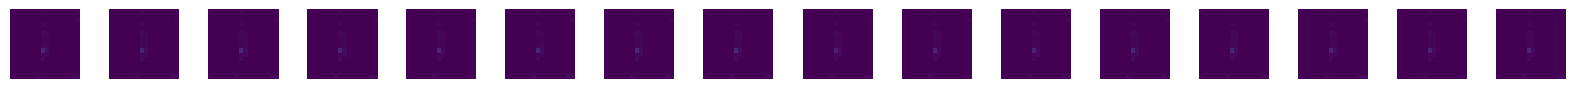

[Epoch 85/100] [D loss: 0.6892] [G loss: 3.8627] [Validity_loss: 0.1146] 
 [Stat_loss: 3.7023] [NNZ_loss: 0.0459]
Sample feature coding: [ 1.         -0.14459425  0.48063922  0.02154224  0.8306397   0.00884852
  0.03945764  0.00357174  0.02300771]


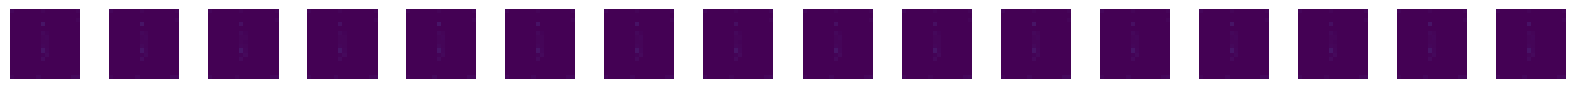

[Epoch 86/100] [D loss: 0.6778] [G loss: 2.0163] [Validity_loss: 0.1133] 
 [Stat_loss: 1.8504] [NNZ_loss: 0.0526]
Sample feature coding: [1.         0.985477   0.07605184 0.5566559  0.7825214  0.0091984
 0.05712055 0.00408556 0.01999988]


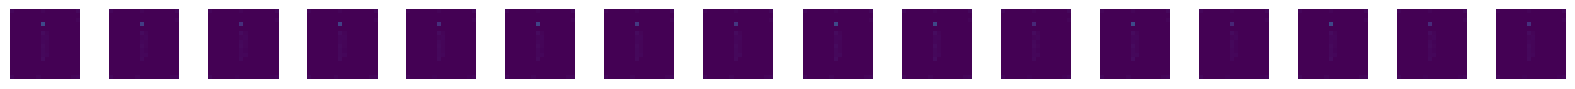

[Epoch 87/100] [D loss: 0.6868] [G loss: 0.6586] [Validity_loss: 0.1033] 
 [Stat_loss: 0.5006] [NNZ_loss: 0.0547]
Sample feature coding: [ 1.         -0.05211463  0.18834618  0.39598873  0.46837413  0.0111123
  0.05294206  0.00365004  0.03525011]


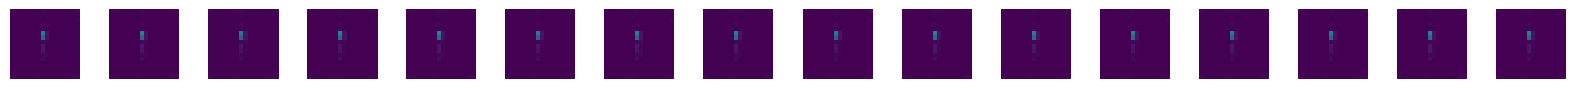

[Epoch 88/100] [D loss: 0.6730] [G loss: 2.4068] [Validity_loss: 0.1077] 
 [Stat_loss: 2.2449] [NNZ_loss: 0.0542]
Sample feature coding: [1.         1.2593931  0.40425378 0.7450845  0.65487486 0.00963915
 0.06140404 0.00399183 0.0324618 ]


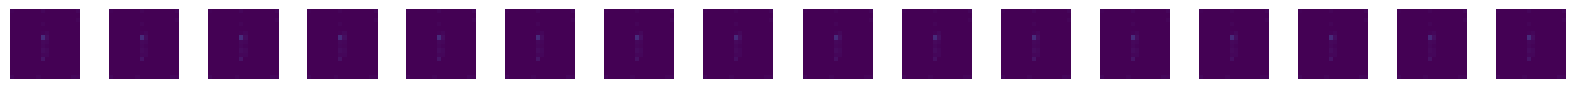

[Epoch 89/100] [D loss: 0.6772] [G loss: 5.0721] [Validity_loss: 0.1250] 
 [Stat_loss: 4.8905] [NNZ_loss: 0.0566]
Sample feature coding: [1.         1.5995876  0.38585216 0.2488467  0.61356586 0.01005306
 0.0729301  0.003951   0.03168325]


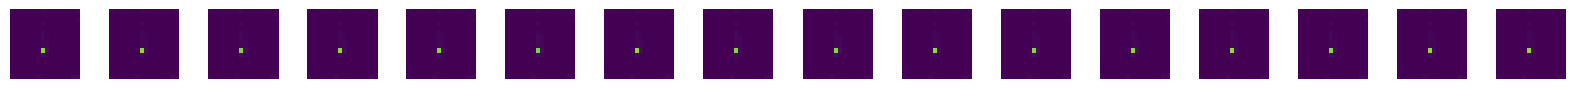

[Epoch 90/100] [D loss: 0.6131] [G loss: 10.9832] [Validity_loss: 0.1224] 
 [Stat_loss: 10.8123] [NNZ_loss: 0.0485]
Sample feature coding: [ 1.         -0.92567223  0.8878005   0.63265806  0.44570526  0.00838566
  0.05263101  0.00399321  0.03845622]


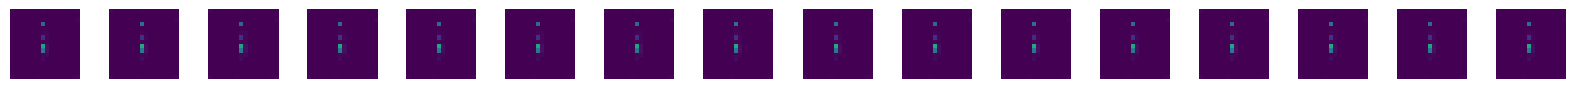

[Epoch 91/100] [D loss: 0.7147] [G loss: 3.0534] [Validity_loss: 0.1330] 
 [Stat_loss: 2.8632] [NNZ_loss: 0.0571]
Sample feature coding: [ 0.         -1.0394021   0.90888095  0.15020698  0.8197414   0.01101314
  0.06010785  0.00347292  0.02887671]


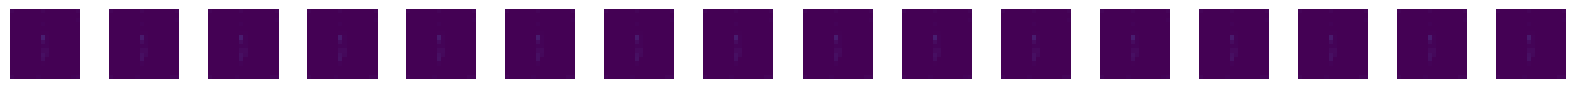

[Epoch 92/100] [D loss: 0.6707] [G loss: 249.7700] [Validity_loss: 0.1324] 
 [Stat_loss: 249.5767] [NNZ_loss: 0.0608]
Sample feature coding: [0.         1.2809396  0.04536311 0.563154   0.46027616 0.00835375
 0.04478049 0.00367129 0.03107507]


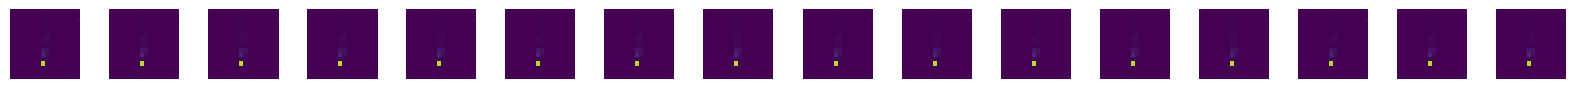

[Epoch 93/100] [D loss: 0.6586] [G loss: 3.2101] [Validity_loss: 0.1348] 
 [Stat_loss: 3.0156] [NNZ_loss: 0.0597]
Sample feature coding: [1.         1.7175609  0.88484    0.70353204 0.4904971  0.00936012
 0.0715747  0.00398069 0.02686993]


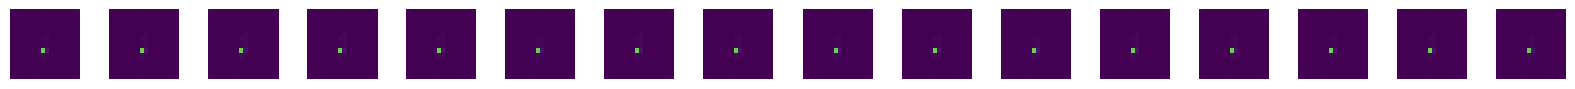

[Epoch 94/100] [D loss: 0.6335] [G loss: 3.5315] [Validity_loss: 0.1328] 
 [Stat_loss: 3.3444] [NNZ_loss: 0.0543]
Sample feature coding: [ 1.         -0.72176594  0.22016372  0.4603773   0.593367    0.00848622
  0.02824465  0.0040091   0.04318192]


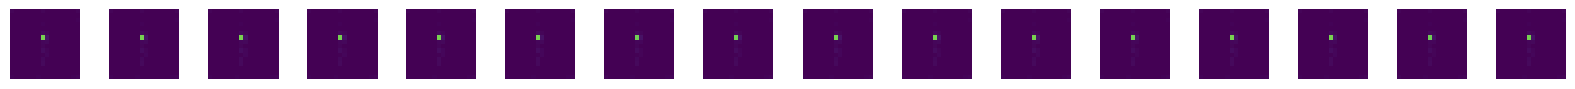

[Epoch 95/100] [D loss: 0.6430] [G loss: 4.8412] [Validity_loss: 0.1147] 
 [Stat_loss: 4.6804] [NNZ_loss: 0.0461]
Sample feature coding: [0.         1.0792046  0.3348702  0.5193531  0.40031832 0.01049023
 0.04927826 0.00364072 0.01730877]


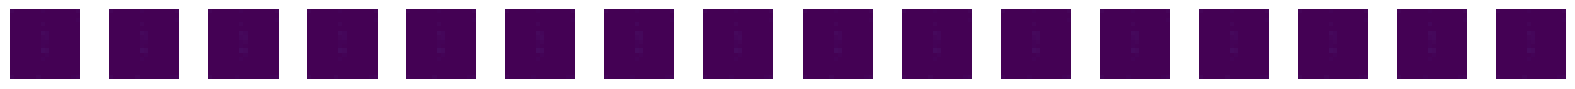

[Epoch 96/100] [D loss: 0.7186] [G loss: 46.7265] [Validity_loss: 0.1137] 
 [Stat_loss: 46.5632] [NNZ_loss: 0.0495]
Sample feature coding: [0.         0.06021964 0.0319014  0.07389598 0.39477718 0.01037539
 0.07630068 0.00416212 0.03376488]


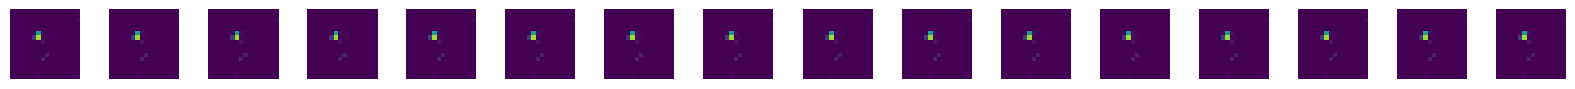

[Epoch 97/100] [D loss: 0.6642] [G loss: 7.1815] [Validity_loss: 0.1176] 
 [Stat_loss: 7.0103] [NNZ_loss: 0.0537]
Sample feature coding: [1.         1.1704549  0.6813713  0.4318298  0.5324085  0.01035257
 0.04879083 0.00415683 0.02061281]


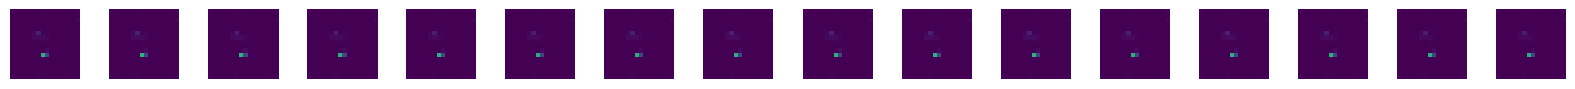

[Epoch 98/100] [D loss: 0.5980] [G loss: 2.3102] [Validity_loss: 0.1552] 
 [Stat_loss: 2.0988] [NNZ_loss: 0.0562]
Sample feature coding: [0.         1.4839957  0.7906833  0.36894396 0.9105812  0.00908173
 0.05590997 0.00403491 0.02152242]


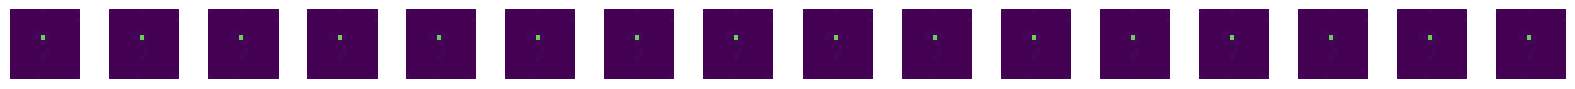

[Epoch 99/100] [D loss: 0.8417] [G loss: 59.0618] [Validity_loss: 0.1070] 
 [Stat_loss: 58.9025] [NNZ_loss: 0.0523]
Sample feature coding: [1.         0.98086095 0.55881816 0.6352254  0.9145798  0.00948338
 0.0404291  0.00390852 0.01694055]


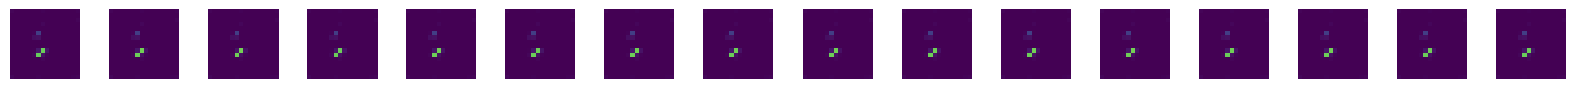

[Epoch 100/100] [D loss: 0.6956] [G loss: 1.1259] [Validity_loss: 0.1281] 
 [Stat_loss: 0.9434] [NNZ_loss: 0.0545]
Sample feature coding: [1.         1.7052234  0.9241066  0.4763265  0.70780116 0.009192
 0.03642145 0.00360804 0.02333733]


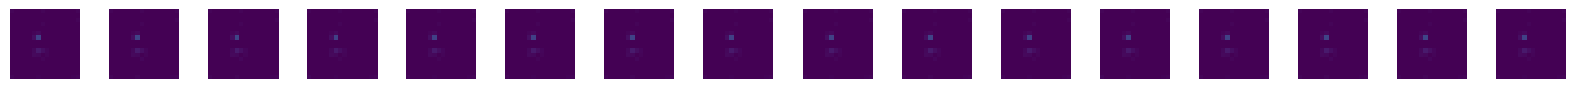

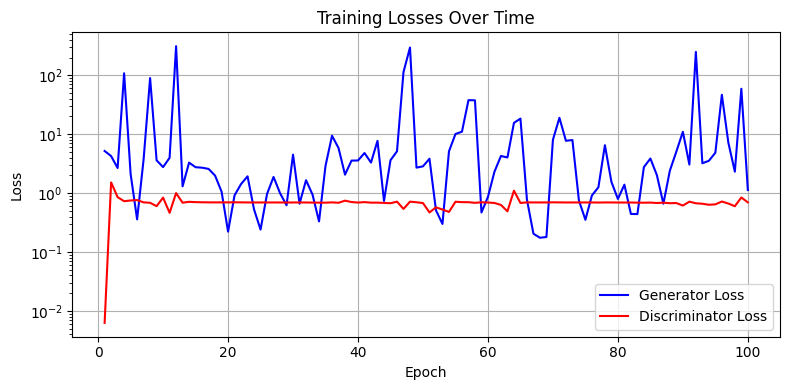

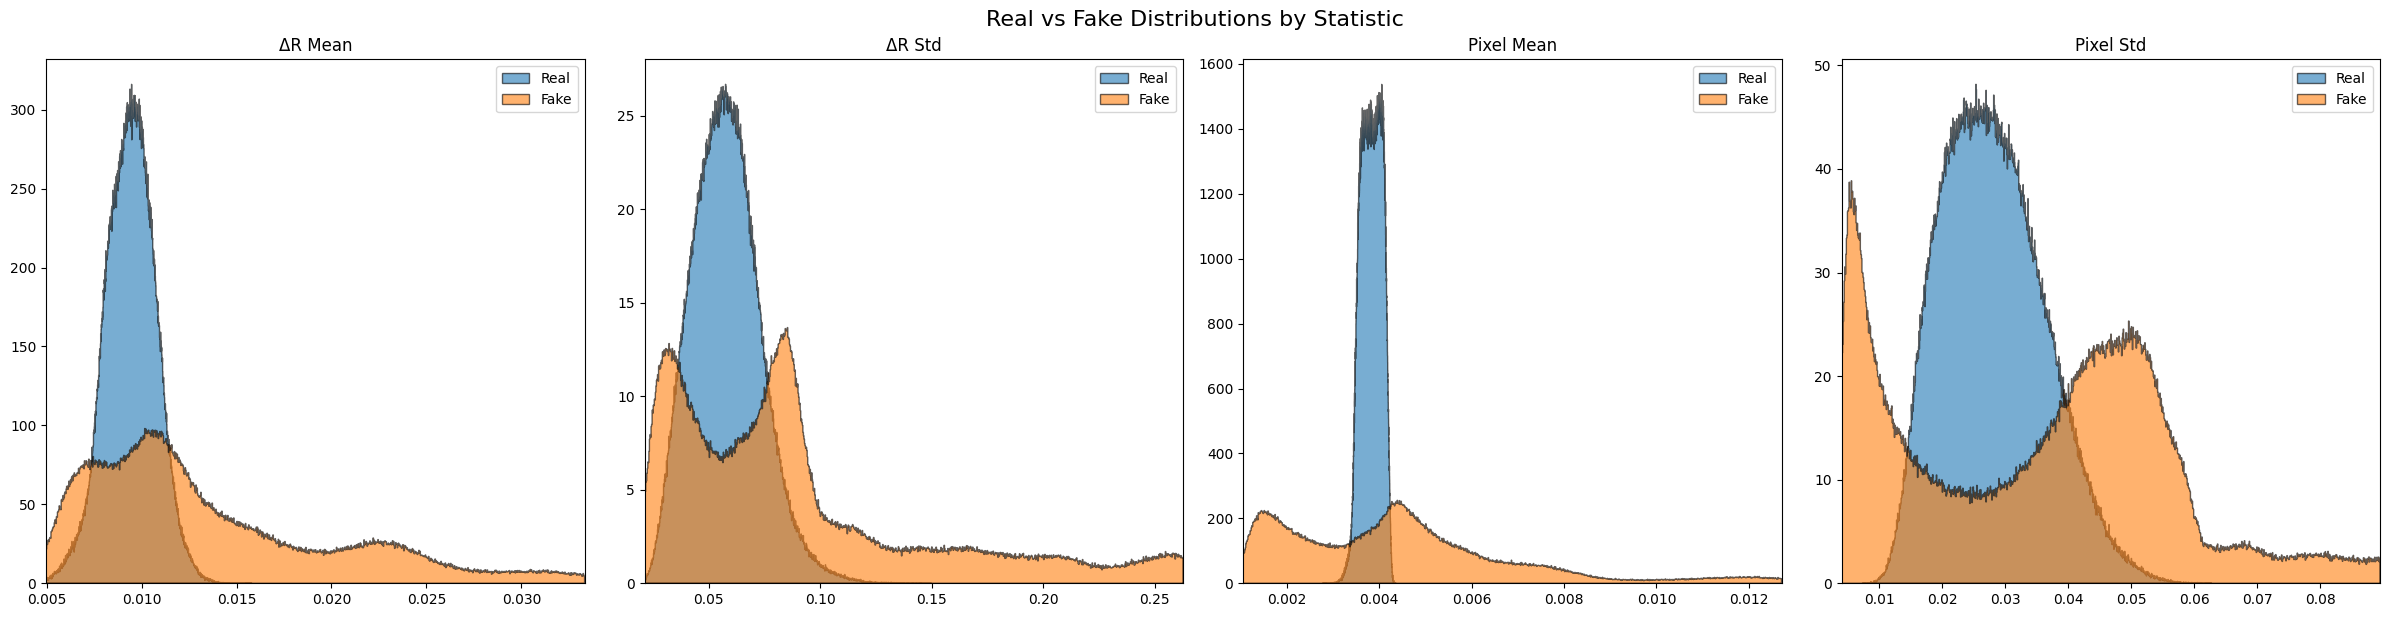

In [9]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.to(device)
        real_flipped_feat = flipped_features.to(device)
        real_img = real_image.unsqueeze(1).to(device)
        real_flipped_img = flipped_image.unsqueeze(1).to(device)

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values get passed to the generator, then the output image passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)
            # z_noise = torch.randn(batch_size, 5, ).to(device)
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).to(device)

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)
            # z_noise = torch.randn(batch_size, 5, ).to(device)
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1

            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)

            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            ## Stat loss
            # Compute fake statistics
            fake_stats = compute_fake_statistics(fake_img.to('cpu'), dists.to('cpu'))

            fake_dR_mean = fake_stats['fake_dR_mean'].to(device)
            fake_dR_std = fake_stats['fake_dR_std'].to(device)
            fake_pixel_mean = fake_stats['fake_pixel_mean'].to(device)
            fake_pixel_std = fake_stats['fake_pixel_std'].to(device)
            
            # Get real stats from z_codings (features 5–8)
            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]
            
            real_stats = {
                'real_dR_mean': real_dR_mean,
                'real_dR_std': real_dR_std,
                'real_pixel_mean': real_pixel_mean,
                'real_pixel_std': real_pixel_std
            }
            
            # track_statistics(stats_dict, fake_stats, real_stats)
            # plot_tracked_statistics(stats_dict)
            
            if n_epochs - epoch <= 10:
                # Track the last statistics
                track_statistics(stats_dict, fake_stats, real_stats)

            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl1 = kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / 0.003
            # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
            
            kl2 = kde_kl_divergence_torch(real_dR_std, fake_dR_std) / 0.003
            # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
            
            kl3 = kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / 0.00025
            # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
            
            kl4 = kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / 0.00015
            # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")
            
            kl_total = kl1 + kl2 + kl3 + kl4

            stat_loss = kl_total
            
            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .08
            beta = .001
            chi = 1

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

plot_tracked_statistics(stats_dict)

In [ ]:
## Save Model
# Create output directory if it doesn't exist

save = False

if save:
    os.makedirs("models", exist_ok=True)

    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/class_gan_short_model_{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

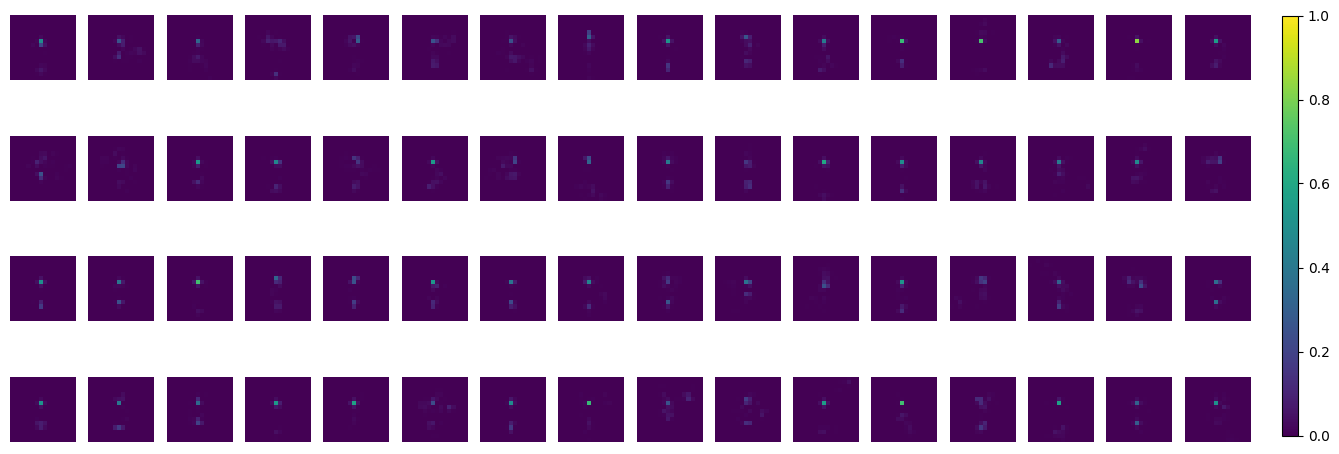

In [10]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images.min()
vmax = dataset.images.max()
N = dataset.images.shape[0]

# Show images and keep the first imshow object for colorbar
for i in range(n_images):
    n = torch.randint(N, ())
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[n], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Sample feature coding: [ 0.         -0.44639853  0.8967468   0.2732396   0.7625968   0.00683524
  0.08833069  0.00366313  0.02541397]


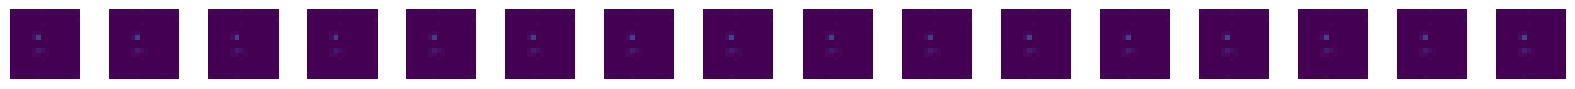

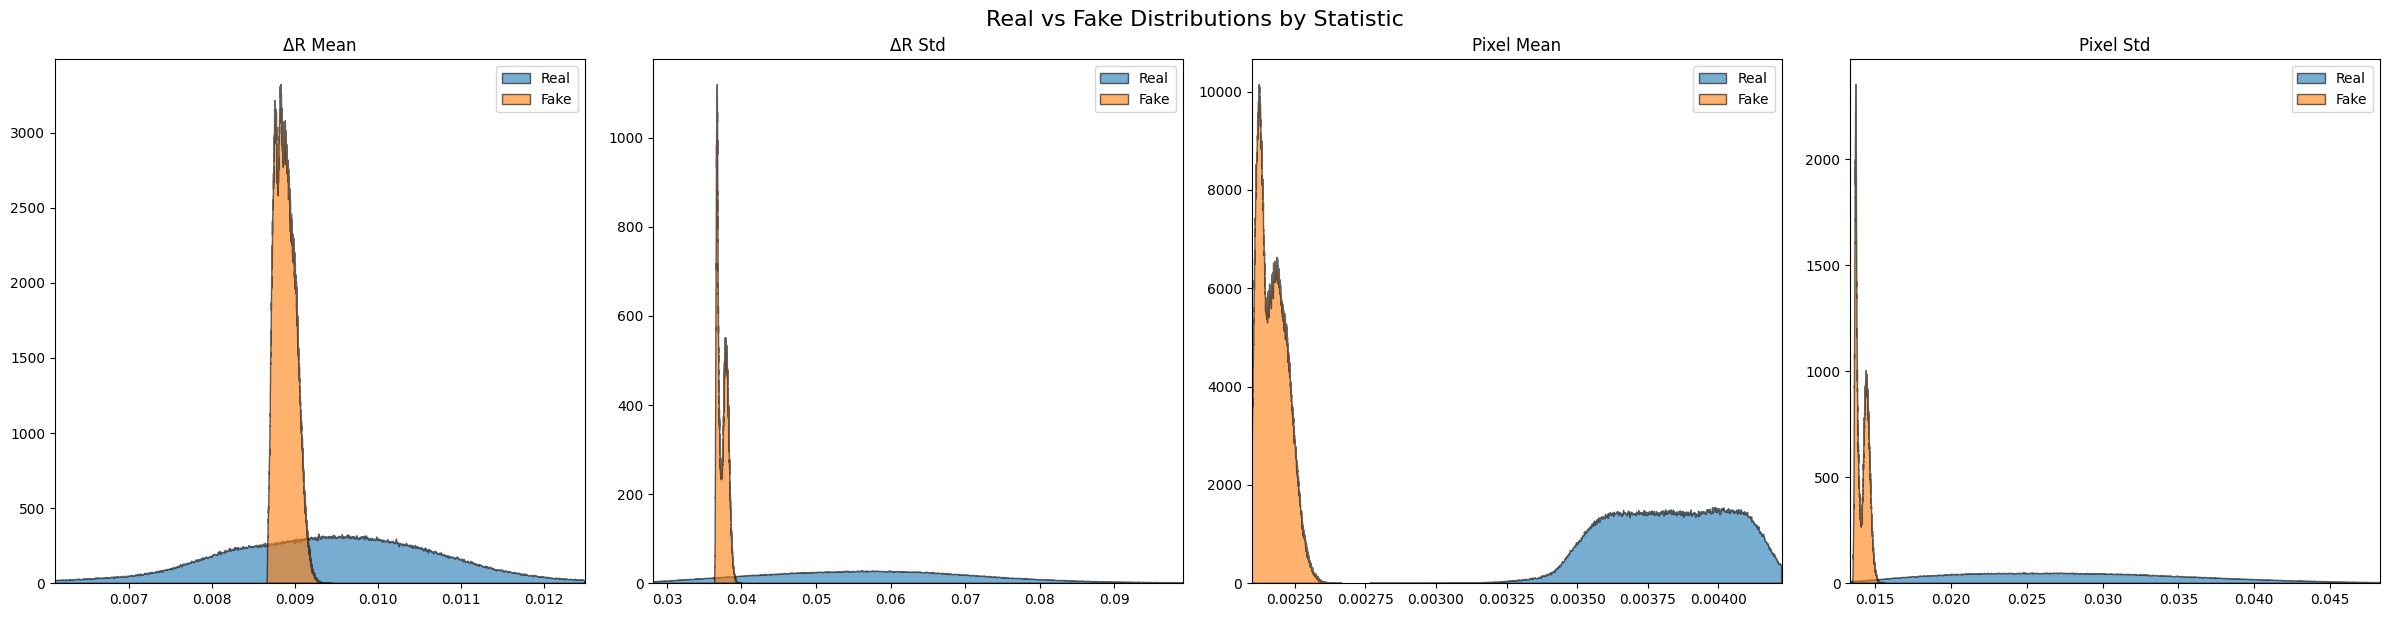

Discriminator output (wrong label): [0.42133415 0.43872967 0.5001535  ... 0.42821327 0.46488288 0.4729687 ]
Discriminator output (correct label): [0.46586016 0.48098603 0.47104317 ... 0.47686404 0.46566787 0.47758475]
Real labels: [1. 1. 1. ... 1. 1. 1.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [ -9.557808    -8.785361     6.1799645  ... -10.202229    -0.16857386
  -0.96654296]


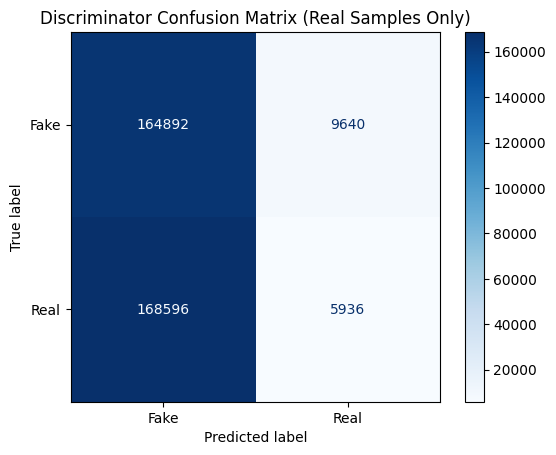

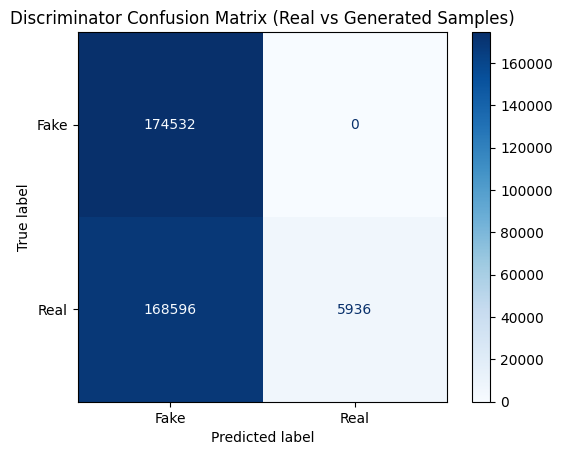

In [11]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=1000000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True